In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os

---
# 1-Prepare Data
---



## Download Data

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 775, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 775 (delta 1), reused 10 (delta 1), pack-reused 762
Receiving objects: 100% (775/775), 14.63 GiB | 43.88 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Checking out files: 100% (186/186), done.


In [ ]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

20200418
20200504
20210630
20200720
20210206
20210603
20201012
20210714
20200919
20200824
20201130
20210816
20200820
20200430
20200424
20201031
20200416
20210830
20210523
20210618
20200707
20200413
20200604
20210406
20200419
20200415
20200901
20200505
20210426
20200502
20210419
20220116
20200525
20210930
20200911
20200814
20200803
20210914
20201221
20200417
20200930
20210507


In [2]:
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'

--2022-02-14 20:15:18--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  1.60MB/s    in 4m 59s  

2022-02-14 20:20:19 (3.04 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]



In [ ]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData1=pd.concat(df_list)
CosData1['DataSet'] = 'coswara'
CosData1.head()

100%|██████████| 2373/2373 [00:37<00:00, 63.12it/s]


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,xyM7qnHrkeSfQsGyRCsomcKfMDG3,healthy,/content/Coswara-Data/20200419/xyM7qnHrkeSfQsG...,0,0,coswara
0,RgfYXoDTg6MBu6V0xKMEjsMfY8m2,no_resp_illness_exposed,/content/Coswara-Data/20200419/RgfYXoDTg6MBu6V...,0,0,coswara
0,OnSOmvzzE2WLcwfrSyNbh0B89n72,resp_illness_not_identified,/content/Coswara-Data/20200419/OnSOmvzzE2WLcwf...,0,0,coswara
0,MEEGIoNSX4exg4oIL3Q9MdysPJq1,healthy,/content/Coswara-Data/20200419/MEEGIoNSX4exg4o...,0,0,coswara
0,Uy5OhcHEQXY65CsYbiRPtN7RVBf1,healthy,/content/Coswara-Data/20200419/Uy5OhcHEQXY65Cs...,0,0,coswara


In [ ]:
positive_mild = CosData1.loc[CosData1['STATUS']=='positive_mild']
positive_moderate	 = CosData1.loc[CosData1['STATUS']=='positive_moderate']
positive_asymp = CosData1.loc[CosData1['STATUS']=='positive_asymp']

positive = pd.concat([positive_mild,positive_moderate,positive_asymp])

healthy = CosData1.loc[CosData1['STATUS']=='healthy']
resp_illness_not_identified = CosData1.loc[CosData1['STATUS']=='resp_illness_not_identified']
no_resp_illness_exposed = CosData1.loc[CosData1['STATUS']=='no_resp_illness_exposed']
recovered_full = CosData1.loc[CosData1['STATUS']=='recovered_full']

negative =  pd.concat([healthy,resp_illness_not_identified,no_resp_illness_exposed,recovered_full])

print(len(positive))
print(len(negative))

f_negative = negative.loc[negative['STATUS']!='COVID-19'][0:550]
print(len(f_negative))



522
1851
550


In [ ]:
CosData   = pd.concat([positive,f_negative])
CosData   = CosData.sample(frac=1)

CosData.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,OC99RqHzOjNvaA0rJhPUgP4PM2o1,healthy,/content/Coswara-Data/20210830/OC99RqHzOjNvaA0...,0,0,coswara
0,Fh3hBZZRh2UXXicTNGMei8ikbSu2,positive_asymp,/content/Coswara-Data/20210406/Fh3hBZZRh2UXXic...,0,0,coswara
0,ZIsSazVaDRZmnV0GzL164wnjQGV2,healthy,/content/Coswara-Data/20200417/ZIsSazVaDRZmnV0...,0,0,coswara
0,R4AY1hLOZtUJRsYeDGgGZR4sKVP2,healthy,/content/Coswara-Data/20200424/R4AY1hLOZtUJRsY...,0,0,coswara
0,HK3FfcI5SyXc7CtQMaQiMQ2ia1n2,positive_asymp,/content/Coswara-Data/20210603/HK3FfcI5SyXc7Ct...,0,0,coswara


## Prepare dataset

In [10]:
coughvid  = '/content/public_dataset/'
custpath  = '/content/custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19']

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
## TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
0,6f52783a-df32-47e7-8429-e2ec42926fd9,0,0,symptomatic,/content/public_dataset/6f52783a-df32-47e7-842...,coughvid
1,fb880c3c-ca39-4456-80f2-a5f6c20614ae,0,0,healthy,/content/public_dataset/fb880c3c-ca39-4456-80f...,coughvid
2,79a12ab8-7497-4a70-871f-5486c6699f45,0,0,symptomatic,/content/public_dataset/79a12ab8-7497-4a70-871...,coughvid
3,6d9ea08f-896a-4320-92ec-4eb20c59a18c,0,0,healthy,/content/public_dataset/6d9ea08f-896a-4320-92e...,coughvid
4,4c0d7af1-ab1c-4cc9-a7e7-1de5222363c2,0,0,healthy,/content/public_dataset/4c0d7af1-ab1c-4cc9-a7e...,coughvid


In [11]:
TotData2 = TotData["STATUS"].unique()
print(TotData2)

['symptomatic' 'healthy' 'COVID-19']


In [89]:
covid_TotData = TotData[TotData["STATUS"] == "COVID-19" ]
symptomatic_TotData = TotData[TotData["STATUS"] == "symptomatic" ]
healthy_TotData = TotData[TotData["STATUS"] == "healthy" ]

print(len(covid_TotData) , len(symptomatic_TotData) , len(healthy_TotData))
covid_TotData.head()




441 949 4702


,ID,Fever/MP,ORC,STATUS,DIR,DataSet
13,46c6c8ef-8b3d-42a1-b4a1-e86e6aeb1664,1,1,COVID-19,/content/public_dataset/46c6c8ef-8b3d-42a1-b4a...,coughvid
29,40de29df-7881-4cbf-9339-809f6a48ba39,0,0,COVID-19,/content/public_dataset/40de29df-7881-4cbf-933...,coughvid
42,e58d45f3-7d6e-48e6-801b-eafc15f1ec85,1,1,COVID-19,/content/public_dataset/e58d45f3-7d6e-48e6-801...,coughvid
43,015ec831-e765-44ee-aefc-10dfd95dec78,1,1,COVID-19,/content/public_dataset/015ec831-e765-44ee-aef...,coughvid
51,25b750e5-8a76-4c13-9fd8-851e45d1b5ed,0,1,COVID-19,/content/public_dataset/25b750e5-8a76-4c13-9fd...,coughvid


# Data Augmentaion

In [ ]:
pip install audiomentations

In [16]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf
import librosa

In [171]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

os.makedirs("augmented_data")
idx=0;
for audio_file in tqdm(covid_TotData["DIR"]):
  try:
    samples, sr = librosa.load(audio_file) #get audio file from dataset
    print(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data/" + audio_file.split("/")[-1][0:-5] + ".wav", augmented_sample, sr) #write with wav extantion
    print("\nhi")
    if idx ==0:
      aug_positive_samples = covid_TotData.loc[covid_TotData['ID'] == audio_file.split("/")[-1][0:-5]]
    else:
      aug_positive_samples = aug_positive_samples.append(covid_TotData.loc[covid_TotData['ID'] == audio_file.split("/")[-1][0:-5]],ignore_index=True)
    idx=idx + 1
  except:
    print("\n File Not Found :))")

  0%|          | 1/441 [00:00<04:16,  1.72it/s]

/content/public_dataset/46c6c8ef-8b3d-42a1-b4a1-e86e6aeb1664.webm

hi
/content/public_dataset/40de29df-7881-4cbf-9339-809f6a48ba39.webm


  0%|          | 2/441 [00:01<06:32,  1.12it/s]


hi
/content/public_dataset/e58d45f3-7d6e-48e6-801b-eafc15f1ec85.webm


  1%|          | 3/441 [00:02<07:17,  1.00it/s]


hi


  1%|          | 4/441 [00:03<06:33,  1.11it/s]

/content/public_dataset/015ec831-e765-44ee-aefc-10dfd95dec78.webm

hi


  1%|          | 5/441 [00:04<06:25,  1.13it/s]

/content/public_dataset/25b750e5-8a76-4c13-9fd8-851e45d1b5ed.webm

hi


  1%|▏         | 6/441 [00:05<05:39,  1.28it/s]

/content/public_dataset/1b1f2c9b-7cfa-4eb5-837d-36ae3d647c92.webm

hi


  2%|▏         | 7/441 [00:05<04:47,  1.51it/s]

/content/public_dataset/9a927cb5-465b-48a3-a36d-6411f5878790.webm

hi
/content/public_dataset/96678e97-6a39-4932-9c5d-13981167bbd8.webm


  2%|▏         | 8/441 [00:06<05:50,  1.24it/s]


hi
/content/public_dataset/a0bd7465-ae76-40cd-903b-3591ed9595db.webm


  2%|▏         | 9/441 [00:07<06:32,  1.10it/s]


hi
/content/public_dataset/240021ec-048e-431d-9548-11d7c234389e.webm


  2%|▏         | 10/441 [00:08<07:04,  1.01it/s]


hi


  2%|▏         | 11/441 [00:09<06:33,  1.09it/s]

/content/public_dataset/37347587-048a-4a1c-a100-7cf820711428.webm

hi


  3%|▎         | 12/441 [00:10<05:46,  1.24it/s]

/content/public_dataset/6f2e1f59-6d57-499a-8c26-978d80255271.webm

hi


  3%|▎         | 13/441 [00:10<05:38,  1.26it/s]

/content/public_dataset/1d471862-8805-411b-bd10-2b8e9ffdf718.webm

hi


  3%|▎         | 14/441 [00:11<05:44,  1.24it/s]

/content/public_dataset/16f9b161-86c6-4af1-99cb-0ab327f10fed.webm

hi


  3%|▎         | 15/441 [00:12<05:38,  1.26it/s]

/content/public_dataset/d994f7f6-43cc-445b-8634-ff3c038ffd53.webm

hi


  4%|▎         | 16/441 [00:12<04:52,  1.46it/s]

/content/public_dataset/6d194cdc-ba5a-40ba-8232-5bf150026c67.webm

hi
/content/public_dataset/6352a786-97a0-4d0a-9dcd-5c68c8effb9b.webm


  4%|▍         | 17/441 [00:13<05:08,  1.38it/s]


hi


  4%|▍         | 18/441 [00:14<04:43,  1.49it/s]

/content/public_dataset/98cf4fc3-ac20-4007-a227-3b89dc43a52c.webm

hi
/content/public_dataset/91678983-1d96-4390-8f09-55df6a75bb36.webm


  4%|▍         | 19/441 [00:15<05:51,  1.20it/s]


hi


  5%|▍         | 20/441 [00:16<05:50,  1.20it/s]

/content/public_dataset/acf267c9-3e4b-4044-8f2f-8cb477a6e1d2.webm

hi
/content/public_dataset/0379c586-c500-483c-83a6-95b63afe6931.webm


  5%|▍         | 21/441 [00:17<06:29,  1.08it/s]


hi
/content/public_dataset/cc47f830-9785-4651-9756-cde2f39fb494.webm


  5%|▍         | 22/441 [00:18<07:38,  1.09s/it]


hi
/content/public_dataset/3e051a0d-5f5e-4ec6-b0e9-6a97c809cc92.webm


  5%|▌         | 23/441 [00:20<09:06,  1.31s/it]


hi


  5%|▌         | 24/441 [00:22<09:52,  1.42s/it]

/content/public_dataset/65e99746-4a0c-4496-8cb0-e234ed1fa93b.webm

hi
/content/public_dataset/7eac138a-818b-49d3-8ff8-2facdb910b71.webm


  6%|▌         | 25/441 [00:23<09:19,  1.34s/it]


hi
/content/public_dataset/4a54513d-cdcf-4ea6-8139-b0f1d33d41d8.webm


  6%|▌         | 26/441 [00:25<10:34,  1.53s/it]


hi
/content/public_dataset/5d61957f-6865-4e0a-b666-03a928f39e92.webm


  6%|▌         | 27/441 [00:26<09:50,  1.43s/it]


hi
/content/public_dataset/6b265018-98b7-4e61-934a-74b2b0bebce9.webm


  6%|▋         | 28/441 [00:28<10:34,  1.54s/it]


hi


  7%|▋         | 29/441 [00:29<09:21,  1.36s/it]

/content/public_dataset/f64f33a5-b6e1-4d5c-ab1b-8d48dd826440.webm

hi


  7%|▋         | 30/441 [00:30<08:53,  1.30s/it]

/content/public_dataset/6604cf63-454a-4b13-9fc9-95eb74566e8e.webm

hi
/content/public_dataset/f9328b47-1943-4dea-a54a-18cc3c5d06e4.webm


  7%|▋         | 31/441 [00:31<08:47,  1.29s/it]


hi
/content/public_dataset/906c93d3-6615-478b-a7a1-803a5a15d360.webm


  7%|▋         | 32/441 [00:33<08:27,  1.24s/it]


hi


  7%|▋         | 33/441 [00:33<07:36,  1.12s/it]

/content/public_dataset/5998a733-5790-4918-adff-cef8e7b12a73.webm

hi
/content/public_dataset/dd87bf69-1802-47aa-9586-b840d685797a.webm


  8%|▊         | 34/441 [00:35<07:40,  1.13s/it]


hi


  8%|▊         | 35/441 [00:35<07:05,  1.05s/it]

/content/public_dataset/28027420-7148-4f4f-a4d1-0884389bc6df.webm

hi


  8%|▊         | 36/441 [00:36<06:40,  1.01it/s]

/content/public_dataset/b97f011c-062b-4fdd-a65d-4f1d8ab1bd09.webm

hi


  8%|▊         | 37/441 [00:37<06:12,  1.09it/s]

/content/public_dataset/814a5c9e-6174-4efa-a378-a990ac566ae2.webm

hi


  9%|▊         | 38/441 [00:38<05:38,  1.19it/s]

/content/public_dataset/6f0a2344-8d8b-4db5-b4c3-cf569ca4f7b9.webm

hi
/content/public_dataset/424f1c61-5421-4da9-b3de-70e2d706867e.webm


  9%|▉         | 39/441 [00:39<06:08,  1.09it/s]


hi
/content/public_dataset/26ce1218-1d55-4f45-a0f5-643c0f92c2c2.webm


  9%|▉         | 40/441 [00:40<06:47,  1.02s/it]


hi
/content/public_dataset/e1259ecf-0b60-4106-9852-61c945065ab1.webm


  9%|▉         | 41/441 [00:41<06:44,  1.01s/it]


hi
/content/public_dataset/6c7893ac-4ca9-47af-8a91-fd0926dd7f39.webm


 10%|▉         | 42/441 [00:42<06:58,  1.05s/it]


hi


 10%|▉         | 43/441 [00:43<05:52,  1.13it/s]

/content/public_dataset/913c4ae7-9245-458d-9ea2-6a2fea6042f8.webm

hi


 10%|▉         | 44/441 [00:43<05:32,  1.20it/s]

/content/public_dataset/49944a66-4aa3-4986-b3de-10efa29e13d4.webm

hi
/content/public_dataset/fd8d6e46-75de-42b3-a7ef-30d5294b915d.webm


 10%|█         | 45/441 [00:44<05:54,  1.12it/s]


hi


 10%|█         | 46/441 [00:45<05:34,  1.18it/s]

/content/public_dataset/a4cc4680-8bb6-4646-b9cf-d77a4e8ada21.webm

hi
/content/public_dataset/f67d8450-f76e-4c47-bbbe-85418e320acb.webm


 11%|█         | 47/441 [00:46<06:03,  1.08it/s]


hi
/content/public_dataset/32ba514c-b6e5-45a5-a62d-a4555084e3ed.webm


 11%|█         | 48/441 [00:47<06:31,  1.00it/s]


hi
/content/public_dataset/64da4ad6-4280-49a1-bd37-e35efd7837c6.webm


 11%|█         | 49/441 [00:48<06:35,  1.01s/it]


hi


 11%|█▏        | 50/441 [00:49<05:36,  1.16it/s]

/content/public_dataset/cd9de27d-87fa-43e6-a452-8cdaba3eae4c.webm

hi
/content/public_dataset/a5025365-abca-4ff4-a335-a692389b7553.webm


 12%|█▏        | 51/441 [00:50<06:19,  1.03it/s]


hi


 12%|█▏        | 52/441 [00:51<05:53,  1.10it/s]

/content/public_dataset/c34d6285-a7d7-4357-9036-cb4a5caec6f6.webm

hi


 12%|█▏        | 53/441 [00:52<05:42,  1.13it/s]

/content/public_dataset/b75bc5f1-f19d-4b79-bf86-99dd5f7f0bc6.webm

hi


 12%|█▏        | 54/441 [00:53<05:21,  1.20it/s]

/content/public_dataset/cf97b7f8-de05-47f8-8a3c-d3ec1672d25f.webm

hi
/content/public_dataset/f515534f-1850-4a2a-9400-6269e7baae16.webm


 12%|█▏        | 55/441 [00:53<05:34,  1.15it/s]


hi


 13%|█▎        | 56/441 [00:54<05:32,  1.16it/s]

/content/public_dataset/88bec0f2-8dbd-44d5-a6c2-de1cf0646737.webm

hi


 13%|█▎        | 57/441 [00:55<05:00,  1.28it/s]

/content/public_dataset/63f4e572-e693-4265-8b77-07f552fc63e9.webm

hi


 13%|█▎        | 58/441 [00:56<04:46,  1.34it/s]

/content/public_dataset/37dac510-2e8a-47a5-b864-d229a46d72bf.webm

hi


 13%|█▎        | 59/441 [00:56<04:46,  1.33it/s]

/content/public_dataset/70450999-745c-43ec-b117-3eefa1b10476.webm

hi
/content/public_dataset/182246b0-9f77-4c40-976e-3c9342619819.webm


 14%|█▎        | 60/441 [00:57<05:33,  1.14it/s]


hi


 14%|█▍        | 61/441 [00:58<05:17,  1.20it/s]

/content/public_dataset/1c21cb68-6ea8-4aa1-af22-2e64007554d7.webm

hi


 14%|█▍        | 62/441 [00:59<04:36,  1.37it/s]

/content/public_dataset/e4729edf-12e5-4ba9-883e-1114c32b90f0.webm

hi


 14%|█▍        | 63/441 [00:59<04:35,  1.37it/s]

/content/public_dataset/e048aa97-7313-48f8-99f7-0f2795bf4a48.webm

hi


 15%|█▍        | 64/441 [01:00<04:07,  1.52it/s]

/content/public_dataset/d8660e7e-fc21-4583-9c37-4e9ca911ad17.webm

hi
/content/public_dataset/92307087-a106-4fd5-919a-a92b57ffd316.webm


 15%|█▍        | 65/441 [01:01<04:59,  1.26it/s]


hi


 15%|█▍        | 66/441 [01:02<05:03,  1.24it/s]

/content/public_dataset/bc27b4fb-a820-4296-a776-0f0943ba1455.webm

hi


 15%|█▌        | 67/441 [01:03<05:05,  1.22it/s]

/content/public_dataset/309f7a85-57c3-4b1f-baa9-d1290d1d1b23.webm

hi
/content/public_dataset/e92ed6f0-70a8-425f-8dee-1b0443381224.webm


 15%|█▌        | 68/441 [01:04<05:23,  1.15it/s]


hi
/content/public_dataset/1fcd577a-af2b-4352-a735-a1d1a7e7d0b1.webm


 16%|█▌        | 69/441 [01:05<05:42,  1.09it/s]


hi


 16%|█▌        | 70/441 [01:05<05:17,  1.17it/s]

/content/public_dataset/756d7aa4-e12a-4eb3-b119-2b8a7db0abb6.webm

hi


 16%|█▌        | 71/441 [01:06<05:18,  1.16it/s]

/content/public_dataset/e56b40e6-935c-41c6-a04f-cfa133d69cec.webm

hi


 16%|█▋        | 72/441 [01:07<05:04,  1.21it/s]

/content/public_dataset/18e49b6e-60e4-4eb1-8de8-e8261576dbfc.webm

hi


 17%|█▋        | 73/441 [01:08<05:05,  1.20it/s]

/content/public_dataset/774bafb8-5d1c-42c5-a0a8-91ba0a85a04b.webm

hi


 17%|█▋        | 74/441 [01:09<04:44,  1.29it/s]

/content/public_dataset/aa4877b2-4820-422b-affe-c3d31c1fc70a.webm

hi


 17%|█▋        | 75/441 [01:09<04:14,  1.44it/s]

/content/public_dataset/65f8a73e-9cf4-480f-8f4f-c31e67753ea7.webm

hi
/content/public_dataset/25a6fb1b-a42c-4728-a2bf-d0613e17d1d7.webm


 17%|█▋        | 77/441 [01:10<03:42,  1.64it/s]


hi

 File Not Found :))
/content/public_dataset/4b89c5e2-1902-4497-af7a-1eda2630656b.webm


 18%|█▊        | 78/441 [01:12<04:53,  1.24it/s]


hi


 18%|█▊        | 79/441 [01:12<04:25,  1.36it/s]

/content/public_dataset/53325adb-0ff2-480a-8af0-fd9da2a10322.webm

hi


 18%|█▊        | 80/441 [01:13<03:54,  1.54it/s]

/content/public_dataset/13b55d58-ad6d-4cb4-933e-80622a4ff240.webm

hi


 18%|█▊        | 81/441 [01:13<03:51,  1.56it/s]

/content/public_dataset/2c38b55e-7a52-4b23-a4a5-f0da83cd2cba.webm

hi


 19%|█▊        | 82/441 [01:14<03:32,  1.69it/s]

/content/public_dataset/8bb8315c-9afe-4205-911f-222c912f980e.webm

hi


 19%|█▉        | 83/441 [01:14<03:39,  1.63it/s]

/content/public_dataset/0ef3c0bc-56c3-44da-bea0-dc31a158414a.webm

hi


 19%|█▉        | 84/441 [01:15<03:24,  1.75it/s]

/content/public_dataset/83e76c73-4e06-4e49-ae0d-354e2974745f.webm

hi


 19%|█▉        | 85/441 [01:16<03:41,  1.61it/s]

/content/public_dataset/8f5531fb-5c2a-450b-b14c-4321085887d8.webm

hi
/content/public_dataset/b1821263-6041-423f-93d6-a174d97bc4d7.webm


 20%|█▉        | 86/441 [01:17<04:16,  1.38it/s]


hi


 20%|█▉        | 87/441 [01:17<04:29,  1.32it/s]

/content/public_dataset/2e41a2bd-6462-407d-8078-9f7b86a54f52.webm

hi


 20%|█▉        | 88/441 [01:18<04:36,  1.27it/s]

/content/public_dataset/ac3929fc-e9e9-40ad-8776-28449a228857.webm

hi
/content/public_dataset/b2d806e7-37d8-4e92-8780-c7b8ed7d7b26.webm


 20%|██        | 89/441 [01:19<05:02,  1.16it/s]


hi


 20%|██        | 90/441 [01:20<04:13,  1.39it/s]

/content/public_dataset/ef3f4a93-0a99-4361-8132-5b41fa26610c.webm

hi
/content/public_dataset/93833a6e-c67c-4c5f-9570-6f36ac22b9e6.webm


 21%|██        | 91/441 [01:21<04:52,  1.20it/s]


hi
/content/public_dataset/1853c64d-a058-471d-8409-84fd2afb5edd.webm


 21%|██        | 92/441 [01:22<05:14,  1.11it/s]


hi


 21%|██        | 93/441 [01:23<04:59,  1.16it/s]

/content/public_dataset/d0900d06-18dd-4fa9-94a7-7dc1e4d0f125.webm

hi


 21%|██▏       | 94/441 [01:23<04:35,  1.26it/s]

/content/public_dataset/5e282c62-6186-4dda-a15b-52b8b59a3b8e.webm

hi
/content/public_dataset/eeae6f7f-bebd-4d8f-9748-d7a59f7628d6.webm


 22%|██▏       | 95/441 [01:24<05:13,  1.10it/s]


hi


 22%|██▏       | 96/441 [01:25<04:55,  1.17it/s]

/content/public_dataset/ffe0658f-bade-4654-ad79-40a468aabb03.webm

hi


 22%|██▏       | 97/441 [01:26<04:54,  1.17it/s]

/content/public_dataset/d2a55629-24e2-4460-8a0a-b7065927ee07.webm

hi
/content/public_dataset/52de6b02-84b4-4e74-9061-983488b4e300.webm


 22%|██▏       | 98/441 [01:27<04:59,  1.15it/s]


hi
/content/public_dataset/edd0f863-340f-4e5b-b4ce-a0ef86db8d9a.webm


 22%|██▏       | 99/441 [01:28<04:45,  1.20it/s]


hi
/content/public_dataset/69e7b5c5-0469-42dd-b68f-9a7f7637425b.webm


 23%|██▎       | 100/441 [01:29<05:15,  1.08it/s]


hi
/content/public_dataset/5a5dccc2-ce4e-4c4e-ab49-a0dcf6f4a2d0.webm


 23%|██▎       | 101/441 [01:30<05:27,  1.04it/s]


hi


 23%|██▎       | 102/441 [01:30<04:53,  1.15it/s]

/content/public_dataset/105d18a9-f281-4e4c-bb7d-1ad9885696c9.webm

hi
/content/public_dataset/17e623e8-7179-4805-889b-83ba37063d21.webm


 23%|██▎       | 103/441 [01:32<05:13,  1.08it/s]


hi
/content/public_dataset/21d95211-da92-44a9-83c7-30f8d4c6d670.webm


 24%|██▎       | 104/441 [01:33<05:27,  1.03it/s]


hi
/content/public_dataset/aa059172-1850-4afe-8809-2fe79603286a.webm


 24%|██▍       | 105/441 [01:34<05:39,  1.01s/it]


hi
/content/public_dataset/bbe5b8d6-21cf-4718-b263-0fb779d13784.webm


 24%|██▍       | 106/441 [01:35<05:50,  1.05s/it]


hi


 24%|██▍       | 107/441 [01:35<04:56,  1.13it/s]

/content/public_dataset/f028405b-2f4f-4379-ba3e-acc7a69f90be.webm

hi
/content/public_dataset/ec1c43c9-5043-4735-9f66-905e47e22b48.webm


 24%|██▍       | 108/441 [01:36<05:12,  1.06it/s]


hi


 25%|██▍       | 109/441 [01:37<04:51,  1.14it/s]

/content/public_dataset/cbc44a45-447f-4143-b0eb-1bb44185b99a.webm

hi
/content/public_dataset/fb0971e2-8ebf-459c-972d-b09d28ae0ca6.webm


 25%|██▍       | 110/441 [01:38<05:08,  1.07it/s]


hi


 25%|██▌       | 111/441 [01:39<04:48,  1.14it/s]

/content/public_dataset/3f9a82e6-93b5-4d80-b8ae-09d36929d437.webm

hi


 25%|██▌       | 112/441 [01:40<04:33,  1.20it/s]

/content/public_dataset/2f63ad4e-0441-454b-a5b1-20c88f864433.webm

hi


 26%|██▌       | 113/441 [01:40<04:21,  1.25it/s]

/content/public_dataset/1a0d7c38-e644-4c5d-9ba0-bf9bdc0bffd6.webm

hi


 26%|██▌       | 114/441 [01:41<04:27,  1.22it/s]

/content/public_dataset/c98b76a0-089e-4552-8649-2804e2d95403.webm

hi
/content/public_dataset/4e47612c-6c09-4580-a9b6-2eb6bf2ab40c.webm


 26%|██▌       | 115/441 [01:42<04:56,  1.10it/s]


hi
/content/public_dataset/8ac2ef46-05fb-4f68-bb2d-ca5b1e51ed7f.webm


 26%|██▋       | 116/441 [01:43<05:17,  1.03it/s]


hi
/content/public_dataset/2de3fb8f-20a6-4fa5-8428-11cad3338d37.webm


 27%|██▋       | 117/441 [01:45<05:40,  1.05s/it]


hi


 27%|██▋       | 118/441 [01:46<05:21,  1.01it/s]

/content/public_dataset/42dcff9d-b2e1-4b9e-bd93-81a0a100d232.webm

hi
/content/public_dataset/b74176fe-cc78-4daa-8541-10ba8968439d.webm

hi


 27%|██▋       | 119/441 [01:46<04:55,  1.09it/s]

/content/public_dataset/4c71fdad-b09a-43be-b8d4-8cd3520c1aa2.webm


 27%|██▋       | 120/441 [01:47<05:07,  1.04it/s]


hi


 27%|██▋       | 121/441 [01:48<04:32,  1.17it/s]

/content/public_dataset/0b0d7e10-8353-4124-a16b-bf96e405f63c.webm

hi


 28%|██▊       | 122/441 [01:49<04:22,  1.21it/s]

/content/public_dataset/e18efb30-aea1-4cf9-aadb-0afe4c51c7df.webm

hi


 28%|██▊       | 123/441 [01:50<04:24,  1.20it/s]

/content/public_dataset/2018bfea-0071-4aca-8d45-18dac4d65199.webm

hi
/content/public_dataset/015576c8-2b03-4dcb-b251-78a984fe86fe.webm


 28%|██▊       | 124/441 [01:51<04:43,  1.12it/s]


hi
/content/public_dataset/a6645b1d-dadc-4258-b03b-c5b3f05d519d.webm


 28%|██▊       | 125/441 [01:52<04:57,  1.06it/s]


hi


 29%|██▊       | 126/441 [01:52<04:27,  1.18it/s]

/content/public_dataset/10344906-5f7c-4d1d-93a8-56585cc33b2f.webm

hi


 29%|██▉       | 127/441 [01:53<04:12,  1.24it/s]

/content/public_dataset/dc17e768-40f6-462e-99ad-80292586ac3a.webm

hi
/content/public_dataset/c6d2eece-2c2b-4192-939e-0096ad9e3332.webm


 29%|██▉       | 128/441 [01:54<04:36,  1.13it/s]


hi


 29%|██▉       | 129/441 [01:55<04:33,  1.14it/s]

/content/public_dataset/8e40d48d-8f5d-4892-8103-451b2679283f.webm

hi
/content/public_dataset/ab5f091d-dfc6-4477-b584-ad2a8c1e804e.webm


 29%|██▉       | 130/441 [01:56<04:25,  1.17it/s]


hi


 30%|██▉       | 131/441 [01:56<04:14,  1.22it/s]

/content/public_dataset/58a3d924-98cd-426f-9b58-cb6240b7d044.webm

hi


 30%|██▉       | 132/441 [01:57<04:06,  1.25it/s]

/content/public_dataset/cc5b8aa6-355a-4f4c-bc88-4f1d5bafc5ad.webm

hi
/content/public_dataset/1a324acb-12f7-4eef-8e8c-0c71a47280e2.webm


 30%|███       | 133/441 [01:58<04:39,  1.10it/s]


hi
/content/public_dataset/21ad6bc4-ecc4-4a22-b940-618bdd7ad20b.webm


 30%|███       | 134/441 [02:00<05:07,  1.00s/it]


hi
/content/public_dataset/f7c0a229-049b-49cb-a6f3-ad2b0e7bb90d.webm


 31%|███       | 135/441 [02:01<05:20,  1.05s/it]


hi
/content/public_dataset/88eed7b2-404d-4a3e-b18d-4eae00669b78.webm


 31%|███       | 136/441 [02:02<05:31,  1.09s/it]


hi
/content/public_dataset/731cbe07-5754-46cf-bb5c-873a670cd5d7.webm


 31%|███       | 137/441 [02:03<05:31,  1.09s/it]


hi


 31%|███▏      | 138/441 [02:04<04:58,  1.02it/s]

/content/public_dataset/bae0c88f-852c-4f3f-8141-d037c777459e.webm

hi
/content/public_dataset/b7b6a650-3276-43fb-90b1-73134b483fb6.webm


 32%|███▏      | 139/441 [02:05<04:44,  1.06it/s]


hi


 32%|███▏      | 140/441 [02:05<04:05,  1.23it/s]

/content/public_dataset/bd14922a-f88e-4b99-a338-360789a40b69.webm

hi
/content/public_dataset/d0d4e84a-3692-46e2-a168-463896fb9d31.webm


 32%|███▏      | 141/441 [02:06<04:33,  1.10it/s]


hi


 32%|███▏      | 142/441 [02:07<04:27,  1.12it/s]

/content/public_dataset/760cb050-4175-4498-817d-a9976e359c52.webm

hi
/content/public_dataset/76a03d41-09de-4d00-b1e6-0cedf0b3dbda.webm


 32%|███▏      | 143/441 [02:08<04:47,  1.04it/s]


hi


 33%|███▎      | 144/441 [02:09<04:37,  1.07it/s]

/content/public_dataset/8e381f25-6bc9-4b5e-b221-f92e340e71b9.webm

hi
/content/public_dataset/22cb791b-2eba-480f-9eb3-69018bd25a04.webm


 33%|███▎      | 145/441 [02:10<04:43,  1.05it/s]


hi
/content/public_dataset/c5a4c854-9d78-4615-9fdd-519e547e972f.webm


 33%|███▎      | 146/441 [02:11<04:34,  1.07it/s]


hi


 33%|███▎      | 147/441 [02:12<04:16,  1.15it/s]

/content/public_dataset/3722d824-c4bc-489d-8a8f-6bb171129e19.webm

hi


 34%|███▎      | 148/441 [02:12<03:46,  1.29it/s]

/content/public_dataset/2cfd466b-baa2-43f2-be7a-be2fb0e6dd66.webm

hi


 34%|███▍      | 149/441 [02:13<03:52,  1.25it/s]

/content/public_dataset/56ecb826-b12c-43d9-b54b-8dedede30b0f.webm

hi
/content/public_dataset/ed4ba184-bc38-4372-84c0-62485a79ec1b.webm


 34%|███▍      | 150/441 [02:14<04:15,  1.14it/s]


hi


 34%|███▍      | 151/441 [02:15<04:12,  1.15it/s]

/content/public_dataset/09126c08-5214-4723-94f1-7b654464eac0.webm

hi
/content/public_dataset/1f6a497a-7d48-4db2-be34-c7760e427427.webm


 34%|███▍      | 152/441 [02:16<04:49,  1.00s/it]


hi
/content/public_dataset/dd489c88-affc-4142-ac56-752c3a433991.webm


 35%|███▍      | 153/441 [02:17<04:53,  1.02s/it]


hi
/content/public_dataset/5287e036-c41e-4527-93de-c6cdbf1a8461.webm


 35%|███▍      | 154/441 [02:19<04:58,  1.04s/it]


hi
/content/public_dataset/0640716b-e287-4181-a653-5b798e8308c8.webm


 35%|███▌      | 155/441 [02:20<05:05,  1.07s/it]


hi
/content/public_dataset/637d6498-1d52-4860-9976-5a7a94f2a0c3.webm


 35%|███▌      | 156/441 [02:21<05:12,  1.10s/it]


hi
/content/public_dataset/bb17ca61-9aa8-45d2-9b3e-52c53965641f.webm


 36%|███▌      | 157/441 [02:22<05:21,  1.13s/it]


hi


 36%|███▌      | 158/441 [02:23<04:46,  1.01s/it]

/content/public_dataset/43d84d62-8837-479b-bcb6-30effd9ecbc3.webm

hi
/content/public_dataset/8fc1ec0d-4d46-4a76-a833-68763de21df1.webm


 36%|███▌      | 159/441 [02:24<05:00,  1.07s/it]


hi
/content/public_dataset/af89b4c6-a942-4dbd-9efb-cc0ae79a9acf.webm


 36%|███▋      | 160/441 [02:25<05:11,  1.11s/it]


hi
/content/public_dataset/c85daa1b-6f5b-4bc7-803b-117cb57953e5.webm


 37%|███▋      | 161/441 [02:26<05:04,  1.09s/it]


hi


 37%|███▋      | 162/441 [02:27<04:12,  1.11it/s]

/content/public_dataset/a0b2c39c-8a24-4984-aa0f-009f13a700c5.webm

hi


 37%|███▋      | 163/441 [02:27<03:58,  1.16it/s]

/content/public_dataset/d8fc622d-69af-4433-9f5d-e885f50966f9.webm

hi


 37%|███▋      | 164/441 [02:28<03:27,  1.33it/s]

/content/public_dataset/d5e56f55-97a1-417d-a724-04d6ef10830e.webm

hi
/content/public_dataset/88024607-e701-4a54-adeb-c4c1ecc282f4.webm


 37%|███▋      | 165/441 [02:29<03:54,  1.18it/s]


hi


 38%|███▊      | 166/441 [02:30<03:43,  1.23it/s]

/content/public_dataset/41bb08e9-6d43-41bc-bca2-a465f7dcf2f3.webm

hi


 38%|███▊      | 167/441 [02:30<03:38,  1.25it/s]

/content/public_dataset/ff8363d2-016d-4738-9499-4c62480886fb.webm

hi


 38%|███▊      | 168/441 [02:31<03:08,  1.45it/s]

/content/public_dataset/a664172f-6df4-44db-bfd4-c735f1edc3e6.webm

hi
/content/public_dataset/c52f9edf-409b-46dc-8d99-b0b6e0e3a336.webm


 38%|███▊      | 169/441 [02:32<03:08,  1.44it/s]


hi
/content/public_dataset/61ca0d5f-b27e-43fa-85d9-1fb58d2d1746.webm


 39%|███▊      | 170/441 [02:33<03:44,  1.21it/s]


hi
/content/public_dataset/15f12b8d-7ba5-444e-975f-f1b26c6e75ae.webm


 39%|███▉      | 171/441 [02:34<04:14,  1.06it/s]


hi
/content/public_dataset/d5e9a1af-2571-40f7-99c7-77cfe71657c5.webm


 39%|███▉      | 172/441 [02:35<04:37,  1.03s/it]


hi
/content/public_dataset/e5a8a140-d910-47da-b3d6-96941e084028.webm


 39%|███▉      | 173/441 [02:36<04:31,  1.01s/it]


hi


 39%|███▉      | 174/441 [02:37<04:02,  1.10it/s]

/content/public_dataset/9c9d5f33-e8e4-4483-a9ba-992fe633e486.webm

hi


 40%|███▉      | 175/441 [02:37<03:35,  1.23it/s]

/content/public_dataset/f8053fc3-bc4e-403b-b9d4-14133cfe83a6.webm

hi


 40%|███▉      | 176/441 [02:38<02:59,  1.47it/s]

/content/public_dataset/0c35e382-31cd-42cb-bc87-8a84b9c52a41.webm

hi


 40%|████      | 177/441 [02:39<03:12,  1.37it/s]

/content/public_dataset/d57d4c31-4f34-41cd-9fdf-84e4df3f2dcc.webm

hi
/content/public_dataset/2089c2bd-d408-429e-9f15-138343a5cc9c.webm


 40%|████      | 178/441 [02:40<03:40,  1.19it/s]


hi


 41%|████      | 179/441 [02:40<03:07,  1.40it/s]

/content/public_dataset/4c56d691-9cda-499c-8613-59a9c5659003.webm

hi
/content/public_dataset/ea15c9f5-e77d-4b3f-803d-443a69d63eed.webm


 41%|████      | 180/441 [02:41<03:38,  1.20it/s]


hi
/content/public_dataset/141ad4b1-d9b2-407d-9e48-913915c02b74.webm


 41%|████      | 181/441 [02:42<04:02,  1.07it/s]


hi
/content/public_dataset/c2fc880a-7b05-4c36-affe-5ffe03dbc2b4.webm


 41%|████▏     | 182/441 [02:43<03:48,  1.13it/s]


hi


 41%|████▏     | 183/441 [02:44<03:36,  1.19it/s]

/content/public_dataset/b60e7ee3-64c2-4982-8212-750b4dbe8c66.webm

hi


 42%|████▏     | 184/441 [02:45<03:40,  1.17it/s]

/content/public_dataset/72eb0edc-42e6-40b5-b788-39d8dae7f353.webm

hi


 42%|████▏     | 185/441 [02:46<03:30,  1.22it/s]

/content/public_dataset/920ae37e-af2e-4e43-a80e-2150a66db6b1.webm

hi


 42%|████▏     | 186/441 [02:46<03:33,  1.20it/s]

/content/public_dataset/618fc43a-4d9d-4dad-8b68-2714b584ccc4.webm

hi


 42%|████▏     | 187/441 [02:47<03:25,  1.24it/s]

/content/public_dataset/c9c4445b-fbd3-4f4d-9ca2-282a669d79c4.webm

hi


 43%|████▎     | 188/441 [02:48<03:26,  1.23it/s]

/content/public_dataset/09115490-33a9-461c-9437-d7f71be057b0.webm

hi


 43%|████▎     | 189/441 [02:49<03:10,  1.32it/s]

/content/public_dataset/36535622-407d-4226-adad-48b010e8ee83.webm

hi


 43%|████▎     | 190/441 [02:50<03:17,  1.27it/s]

/content/public_dataset/bd2778b5-c82c-436f-a0f5-4e3209c6eed7.webm

hi


 43%|████▎     | 191/441 [02:50<03:23,  1.23it/s]

/content/public_dataset/620ded24-220f-4ada-b032-2b5c170b279a.webm

hi


 44%|████▎     | 192/441 [02:51<03:11,  1.30it/s]

/content/public_dataset/28757e31-b8f6-408c-982e-a016170ab3ef.webm

hi


 44%|████▍     | 193/441 [02:52<03:09,  1.31it/s]

/content/public_dataset/14c7b709-ac4d-4aee-bdbc-ac51c11a497e.webm

hi


 44%|████▍     | 194/441 [02:53<03:14,  1.27it/s]

/content/public_dataset/bfa6b379-56e3-4144-ac7c-17d7269e9865.webm

hi


 44%|████▍     | 195/441 [02:53<02:50,  1.44it/s]

/content/public_dataset/4a31db13-a871-43f8-88ed-f5f153e79fa2.webm

hi
/content/public_dataset/a03baece-440f-4026-9705-4fcb2bc9e065.webm


 44%|████▍     | 196/441 [02:54<03:25,  1.19it/s]


hi


 45%|████▍     | 197/441 [02:55<03:01,  1.35it/s]

/content/public_dataset/1cef13ee-037d-49cb-bbd3-bbb44328cd91.webm

hi


 45%|████▍     | 198/441 [02:56<03:02,  1.33it/s]

/content/public_dataset/e339c45d-998d-4f9b-a8f4-300a63985aa2.webm

hi


 45%|████▌     | 199/441 [02:56<03:01,  1.34it/s]

/content/public_dataset/bcb56997-8193-4fbb-9b15-8fcaa5fba53b.webm

hi


 45%|████▌     | 200/441 [02:57<03:00,  1.34it/s]

/content/public_dataset/ee899936-5701-4a8f-a3ab-f3292554a148.webm

hi


 46%|████▌     | 201/441 [02:58<02:50,  1.40it/s]

/content/public_dataset/f7d1f28a-e3a8-4dd9-b7ec-93e04ee023a0.webm

hi
/content/public_dataset/60ab1646-c540-4179-ae54-ca83767edff1.webm


 46%|████▌     | 202/441 [02:59<03:19,  1.20it/s]


hi


 46%|████▌     | 203/441 [03:00<03:12,  1.24it/s]

/content/public_dataset/7d4263a0-687a-4a88-a377-9c1dfd548377.webm

hi
/content/public_dataset/3c6cfda1-3fe9-403d-b5d1-7797420debe2.webm


 46%|████▋     | 204/441 [03:01<03:31,  1.12it/s]


hi
/content/public_dataset/5b5fb2f4-900a-4023-b4fd-c55b66dc065b.webm


 46%|████▋     | 205/441 [03:02<03:43,  1.06it/s]


hi


 47%|████▋     | 206/441 [03:02<03:10,  1.24it/s]

/content/public_dataset/5a783d35-fd85-43d7-9ae7-22db4f523269.webm

hi


 47%|████▋     | 207/441 [03:03<02:50,  1.37it/s]

/content/public_dataset/22dcfcdd-52a8-4b42-9c50-c0a3696382a9.webm

hi


 47%|████▋     | 208/441 [03:03<02:49,  1.38it/s]

/content/public_dataset/777470d7-add6-492a-abed-a2282e7bc061.webm

hi
/content/public_dataset/b05935c3-68d7-4a28-aea9-f92fbe295c6c.webm


 47%|████▋     | 209/441 [03:05<03:12,  1.20it/s]


hi


 48%|████▊     | 210/441 [03:05<03:05,  1.25it/s]

/content/public_dataset/ecbf28e8-bb61-4a27-bd9a-1f5fd8c332d1.webm

hi
/content/public_dataset/f87d25cd-c9b0-409c-be18-39a7f80f2ff0.webm


 48%|████▊     | 211/441 [03:06<03:00,  1.27it/s]


hi


 48%|████▊     | 212/441 [03:07<02:56,  1.30it/s]

/content/public_dataset/ef458365-a016-45ff-842a-7388a89ed774.webm

hi
/content/public_dataset/6aa04a12-6e9a-4b9c-80da-a9fa01fc1757.webm


 48%|████▊     | 213/441 [03:08<03:24,  1.12it/s]


hi
/content/public_dataset/c54e2543-7e25-4a57-83fe-6b227220d00c.webm


 49%|████▊     | 214/441 [03:09<03:35,  1.05it/s]


hi
/content/public_dataset/2561c0c9-c4d4-4d63-8c8a-610d6eafe593.webm


 49%|████▉     | 215/441 [03:10<03:42,  1.01it/s]


hi


 49%|████▉     | 216/441 [03:11<03:11,  1.18it/s]

/content/public_dataset/4c58cf95-9b2e-4091-adaa-0ac06a355c48.webm

hi


 49%|████▉     | 217/441 [03:11<03:08,  1.19it/s]

/content/public_dataset/10aed3ae-9ec1-4041-bac6-90b1d4634aee.webm

hi
/content/public_dataset/9d691598-b7e2-4d3b-a90a-afd4ab47abad.webm


 49%|████▉     | 218/441 [03:13<03:32,  1.05it/s]


hi
/content/public_dataset/3050a1e2-d70b-4f86-9e57-f33220b8f990.webm


 50%|████▉     | 219/441 [03:14<03:25,  1.08it/s]


hi


 50%|████▉     | 220/441 [03:14<03:00,  1.22it/s]

/content/public_dataset/3e4f0ebc-7100-48a8-b164-4d90b8dee8db.webm

hi


 50%|█████     | 221/441 [03:15<03:03,  1.20it/s]

/content/public_dataset/eade4e05-0fe3-4736-8a9c-35467d078113.webm

hi
/content/public_dataset/9aea1b03-9fc0-48c9-9e62-a6ac15633c03.webm


 50%|█████     | 222/441 [03:16<03:17,  1.11it/s]


hi


 51%|█████     | 223/441 [03:17<03:12,  1.13it/s]

/content/public_dataset/195f9381-cf35-45da-b0ae-cc4ed04e9283.webm

hi
/content/public_dataset/583240d0-4e6f-4456-8894-be5a74010add.webm


 51%|█████     | 224/441 [03:18<03:22,  1.07it/s]


hi


 51%|█████     | 225/441 [03:19<03:14,  1.11it/s]

/content/public_dataset/a49d942a-331a-49b5-b755-8659a12fac07.webm

hi


 51%|█████     | 226/441 [03:20<03:09,  1.14it/s]

/content/public_dataset/080b6119-f1ab-4337-93dd-aaccf73b4ee1.webm

hi


 51%|█████▏    | 227/441 [03:20<02:40,  1.34it/s]

/content/public_dataset/be48c56b-4a96-43f7-b45c-46d9c0dfd909.webm

hi


 52%|█████▏    | 228/441 [03:21<02:39,  1.34it/s]

/content/public_dataset/44d6d275-b422-4338-bda2-2d0cc203f72b.webm

hi


 52%|█████▏    | 229/441 [03:21<02:16,  1.55it/s]

/content/public_dataset/e389b2e1-e6a3-4b8d-a6f7-080890003015.webm

hi


 52%|█████▏    | 230/441 [03:22<02:16,  1.55it/s]

/content/public_dataset/b68a0a4e-7622-4426-875e-0dd9d6604224.webm

hi


 52%|█████▏    | 231/441 [03:23<02:29,  1.40it/s]

/content/public_dataset/48ff5e27-832e-4450-9ea5-288a0e6967db.webm

hi


 53%|█████▎    | 232/441 [03:23<02:15,  1.54it/s]

/content/public_dataset/2da2b65c-a06b-48c8-848f-fd905acb9b0a.webm

hi
/content/public_dataset/8ebca537-22d5-45fd-9f1c-60a58622284d.webm


 53%|█████▎    | 233/441 [03:24<02:41,  1.29it/s]


hi


 53%|█████▎    | 234/441 [03:25<02:38,  1.31it/s]

/content/public_dataset/ecc957af-3001-4a29-935a-32db98540746.webm

hi


 53%|█████▎    | 235/441 [03:26<02:45,  1.25it/s]

/content/public_dataset/5aa4dae0-fe23-4eb2-9d62-e6016a1c9f8a.webm

hi


 54%|█████▎    | 236/441 [03:27<02:40,  1.27it/s]

/content/public_dataset/f4e51208-6dcd-46c2-b2f3-f4fa6e6f8760.webm

hi


 54%|█████▎    | 237/441 [03:27<02:33,  1.33it/s]

/content/public_dataset/7f8e60f4-5cbd-4ec6-bc73-e8ab2b6c3abd.webm

hi


 54%|█████▍    | 238/441 [03:28<02:38,  1.28it/s]

/content/public_dataset/563a6cd6-55b0-4895-af02-87de034ae948.webm

hi
/content/public_dataset/ed19d797-397f-4218-8412-14d7f5c25780.webm


 54%|█████▍    | 239/441 [03:29<02:55,  1.15it/s]


hi
/content/public_dataset/c5f4b9fe-04cd-441b-801f-ae24db6b2fc7.webm


 54%|█████▍    | 240/441 [03:30<03:06,  1.08it/s]


hi
/content/public_dataset/9e4f4e7b-541e-4e88-80c8-458f62c12825.webm


 55%|█████▍    | 241/441 [03:31<03:14,  1.03it/s]


hi
/content/public_dataset/70dbb19c-8c7a-45d4-9d2a-cd2272cc7ccb.webm


 55%|█████▍    | 242/441 [03:32<03:04,  1.08it/s]


hi


 55%|█████▌    | 243/441 [03:33<02:59,  1.11it/s]

/content/public_dataset/03d30b8b-03f8-4089-bda8-0e14deec7d82.webm

hi
/content/public_dataset/ab228702-1c84-4514-8ea9-7a207b1919c9.webm


 55%|█████▌    | 244/441 [03:34<03:12,  1.02it/s]


hi
/content/public_dataset/729d23d1-9abd-44df-8b05-22217b1ffbdf.webm


 56%|█████▌    | 245/441 [03:35<03:23,  1.04s/it]


hi
/content/public_dataset/cd05d1d9-ed06-4fa7-b0d7-3e43c89eb45b.webm


 56%|█████▌    | 246/441 [03:37<03:30,  1.08s/it]


hi
/content/public_dataset/274fee77-6d89-4b0f-962e-28969658b430.webm


 56%|█████▌    | 247/441 [03:38<03:33,  1.10s/it]


hi
/content/public_dataset/08d5d346-6219-4e6d-ac06-ef489f2d186c.webm


 56%|█████▌    | 248/441 [03:39<03:34,  1.11s/it]


hi
/content/public_dataset/2e9f905a-697c-48db-883e-7e905873172f.webm


 56%|█████▋    | 249/441 [03:40<03:32,  1.11s/it]


hi


 57%|█████▋    | 250/441 [03:40<02:50,  1.12it/s]

/content/public_dataset/450dbdc0-e479-43a2-b3d2-8e51b8253649.webm

hi
/content/public_dataset/892ba9c4-bc94-49b2-97ce-01fa057a5386.webm


 57%|█████▋    | 251/441 [03:41<03:01,  1.05it/s]


hi
/content/public_dataset/8d33620a-f041-4c6c-b55d-78c1ac9eb8e5.webm


 57%|█████▋    | 252/441 [03:42<03:03,  1.03it/s]


hi


 57%|█████▋    | 253/441 [03:43<02:37,  1.19it/s]

/content/public_dataset/1b7a8173-80be-4905-bdaa-b471b228b1ed.webm

hi


 58%|█████▊    | 254/441 [03:44<02:38,  1.18it/s]

/content/public_dataset/936268f0-41a3-421d-bd18-8e69e597e84c.webm

hi
/content/public_dataset/e56ea219-e97c-45c4-8222-5ecf168445b5.webm


 58%|█████▊    | 255/441 [03:45<02:50,  1.09it/s]


hi
/content/public_dataset/f18097f1-d7d5-4566-a7f1-dce0f2e8da87.webm


 58%|█████▊    | 256/441 [03:46<03:01,  1.02it/s]


hi
/content/public_dataset/e272246a-5c0e-4549-83b0-8330cfce867e.webm


 58%|█████▊    | 257/441 [03:47<03:13,  1.05s/it]


hi


 59%|█████▊    | 258/441 [03:48<02:55,  1.04it/s]

/content/public_dataset/a1f69db9-81f4-4a07-9808-dd1c99053125.webm

hi
/content/public_dataset/95c41fec-38ea-4144-a071-22baf4981bdb.webm


 59%|█████▊    | 259/441 [03:49<02:54,  1.04it/s]


hi
/content/public_dataset/a051a29f-4cf2-49b4-b057-f61b6b34b4fe.webm


 59%|█████▉    | 260/441 [03:50<03:07,  1.04s/it]


hi


 59%|█████▉    | 261/441 [03:51<02:51,  1.05it/s]

/content/public_dataset/563ae851-f40b-490c-99c9-1acf9c269a3c.webm

hi
/content/public_dataset/d57e15cf-e837-4e9e-a777-c3ee24fcb72b.webm


 59%|█████▉    | 262/441 [03:52<02:58,  1.00it/s]


hi


 60%|█████▉    | 263/441 [03:53<02:44,  1.08it/s]

/content/public_dataset/ef101918-6c9e-493e-bad0-a6a83923b926.webm

hi


 60%|█████▉    | 264/441 [03:53<02:28,  1.19it/s]

/content/public_dataset/d90f21db-93fc-4e29-b023-8c2fd6a02931.webm

hi


 60%|██████    | 265/441 [03:54<02:23,  1.23it/s]

/content/public_dataset/6ac1cde9-7727-49d2-848c-983e2e541845.webm

hi


 60%|██████    | 266/441 [03:55<02:18,  1.26it/s]

/content/public_dataset/abbff660-5d13-4c31-b842-bbf2189ff14e.webm

hi
/content/public_dataset/4ff82172-fda0-453c-80f2-1cf5aaffa8f1.webm


 61%|██████    | 267/441 [03:56<02:35,  1.12it/s]


hi
/content/public_dataset/0837bd59-09c5-4098-afe3-4bcbfb0fb0e2.webm


 61%|██████    | 268/441 [03:57<02:44,  1.05it/s]


hi
/content/public_dataset/4934dd77-80e0-42b9-bfc4-995b03b76450.webm


 61%|██████    | 269/441 [03:58<02:50,  1.01it/s]


hi


 61%|██████    | 270/441 [03:59<02:43,  1.05it/s]

/content/public_dataset/ac4ea2db-4fff-4a7f-a5fe-3a9ade2f1020.webm

hi
/content/public_dataset/68be5313-193c-42ca-acdc-f6f93c9c1126.webm


 61%|██████▏   | 271/441 [04:00<02:35,  1.09it/s]


hi
/content/public_dataset/5418a808-f17d-4985-a1eb-5d1ee3647cb0.webm


 62%|██████▏   | 272/441 [04:01<02:41,  1.05it/s]


hi


 62%|██████▏   | 273/441 [04:02<02:34,  1.09it/s]

/content/public_dataset/4fc9a8e3-909a-4e92-9621-d5e578817f21.webm

hi
/content/public_dataset/db052b95-1d01-4995-a6b7-7c5be060d474.webm


 62%|██████▏   | 274/441 [04:03<02:41,  1.04it/s]


hi


 62%|██████▏   | 275/441 [04:03<02:18,  1.20it/s]

/content/public_dataset/fd849b72-f4bf-4852-9bc2-fd9becc9571e.webm

hi


 63%|██████▎   | 276/441 [04:04<02:02,  1.35it/s]

/content/public_dataset/20602da6-a92f-40ad-81d2-1688f5f1fcde.webm

hi
/content/public_dataset/e8537e2a-98b1-4ddd-8237-3835215218b4.webm


 63%|██████▎   | 277/441 [04:05<02:23,  1.14it/s]


hi


 63%|██████▎   | 278/441 [04:06<02:12,  1.23it/s]

/content/public_dataset/33b688eb-cae8-40cb-9d71-694f5d2f417f.webm

hi
/content/public_dataset/9e0490ff-2444-488a-8c01-400b958c9875.webm


 63%|██████▎   | 279/441 [04:07<02:28,  1.09it/s]


hi
/content/public_dataset/197fd3fd-2c59-41b3-836a-8c9d51b3fbb0.webm


 63%|██████▎   | 280/441 [04:08<02:41,  1.00s/it]


hi
/content/public_dataset/43cfe07c-cf76-4d97-914a-b1a1ec2c9759.webm


 64%|██████▎   | 281/441 [04:09<02:46,  1.04s/it]


hi


 64%|██████▍   | 282/441 [04:10<02:31,  1.05it/s]

/content/public_dataset/daf72e17-3529-4037-8fee-3852396f059b.webm

hi
/content/public_dataset/9031d3b2-4019-403f-9c71-f387e6b60a82.webm


 64%|██████▍   | 283/441 [04:11<02:40,  1.02s/it]


hi


 64%|██████▍   | 284/441 [04:12<02:13,  1.18it/s]

/content/public_dataset/be265d6b-9bc3-4499-a099-940ad4479dde.webm

hi
/content/public_dataset/4afa3822-6de3-4877-b5ee-2e4e7ffb9081.webm


 65%|██████▍   | 285/441 [04:13<02:27,  1.06it/s]


hi
/content/public_dataset/21db7316-4810-4156-8892-fbd4620867d4.webm


 65%|██████▍   | 286/441 [04:14<02:31,  1.02it/s]


hi


 65%|██████▌   | 287/441 [04:15<02:26,  1.05it/s]

/content/public_dataset/7d2e208f-4b40-43c8-8f85-e05f9671db2c.webm

hi
/content/public_dataset/8f71d0b4-c179-44a9-afb5-cc85047aca9d.webm


 65%|██████▌   | 288/441 [04:16<02:17,  1.11it/s]


hi
/content/public_dataset/0d1cb244-e3cb-404d-97f5-99592b92da44.webm


 66%|██████▌   | 289/441 [04:17<02:31,  1.00it/s]


hi


 66%|██████▌   | 290/441 [04:18<02:19,  1.08it/s]

/content/public_dataset/7cd1efb7-e973-492d-8a2c-e00a42ef0d78.webm

hi


 66%|██████▌   | 291/441 [04:18<02:00,  1.24it/s]

/content/public_dataset/c261cdbc-fb1e-4444-8b68-33c920047d8c.webm

hi


 66%|██████▌   | 292/441 [04:19<01:49,  1.36it/s]

/content/public_dataset/178f39e2-a261-4ec6-a8fb-3f89c3c795bb.webm

hi
/content/public_dataset/0c4da14c-7035-41b7-ade2-38aa1481c046.webm


 66%|██████▋   | 293/441 [04:20<02:09,  1.15it/s]


hi
/content/public_dataset/f4e4e818-c210-4c9e-bdca-c1cf1af1e144.webm


 67%|██████▋   | 294/441 [04:21<02:21,  1.04it/s]


hi


 67%|██████▋   | 295/441 [04:22<02:10,  1.12it/s]

/content/public_dataset/493632f2-537a-4a36-a932-268a8aa59486.webm

hi


 67%|██████▋   | 296/441 [04:22<01:55,  1.26it/s]

/content/public_dataset/48834369-72f5-4bbb-847c-5636af5a6882.webm

hi


 67%|██████▋   | 297/441 [04:23<01:38,  1.47it/s]

/content/public_dataset/bdd15ab3-7347-4a29-b5f2-6a63f70bfe6a.webm

hi
/content/public_dataset/a5aeaa95-ed25-452b-b112-62c042c21b33.webm


 68%|██████▊   | 298/441 [04:24<01:55,  1.24it/s]


hi


 68%|██████▊   | 299/441 [04:25<01:54,  1.24it/s]

/content/public_dataset/18c36541-7566-4f46-8264-3716e2e71f30.webm

hi
/content/public_dataset/b392ae80-f91a-4a78-bad3-2e8a8c8130d2.webm


 68%|██████▊   | 300/441 [04:26<01:56,  1.21it/s]


hi


 68%|██████▊   | 301/441 [04:26<01:43,  1.35it/s]

/content/public_dataset/87dcbffa-7685-46d7-a67a-d16e09b33cc0.webm

hi


 68%|██████▊   | 302/441 [04:27<01:31,  1.52it/s]

/content/public_dataset/56994aa1-4626-4782-9f27-f125adfd120a.webm

hi
/content/public_dataset/bac8326b-2652-443d-8b58-af96cdf5284d.webm


 69%|██████▊   | 303/441 [04:28<01:54,  1.21it/s]


hi
/content/public_dataset/1dd3b212-e969-4ede-a9d9-f24b711e2028.webm


 69%|██████▉   | 304/441 [04:29<02:06,  1.08it/s]


hi
/content/public_dataset/3af1ee7b-2411-4cb0-afb1-e49d2c9a9cad.webm


 69%|██████▉   | 305/441 [04:30<02:04,  1.09it/s]


hi


 69%|██████▉   | 306/441 [04:31<02:01,  1.11it/s]

/content/public_dataset/51e2e40b-f1cd-45ba-ad05-8219c595235c.webm

hi
/content/public_dataset/e804a68f-0030-4b55-b452-a2fa4f6211ed.webm


 70%|██████▉   | 307/441 [04:32<02:11,  1.02it/s]


hi
/content/public_dataset/aeb567c4-529c-43c7-9075-21537e836d4d.webm


 70%|██████▉   | 308/441 [04:33<02:16,  1.03s/it]


hi


 70%|███████   | 309/441 [04:34<02:04,  1.06it/s]

/content/public_dataset/99b2dc16-7b5f-4d45-99b2-c3768262be3a.webm

hi


 70%|███████   | 310/441 [04:35<02:00,  1.09it/s]

/content/public_dataset/47ceafde-45d9-4bb6-881a-5ef866fa908d.webm

hi


 71%|███████   | 311/441 [04:35<01:55,  1.13it/s]

/content/public_dataset/5f0a1915-2cd5-41fb-9887-e17ab27b515e.webm

hi
/content/public_dataset/4f51059b-0e34-4ae8-8ea8-66630d9b147b.webm


 71%|███████   | 312/441 [04:36<02:01,  1.06it/s]


hi
/content/public_dataset/83c90c0f-3d84-4b60-b422-2b64630d9f7d.webm


 71%|███████   | 313/441 [04:38<02:09,  1.01s/it]


hi
/content/public_dataset/eb74838f-26b9-457e-a4f6-3fff63ebc270.webm


 71%|███████   | 314/441 [04:39<02:13,  1.05s/it]


hi


 71%|███████▏  | 315/441 [04:39<01:49,  1.15it/s]

/content/public_dataset/d5ae4279-5716-4658-ba24-8cb5cf87f40d.webm

hi


 72%|███████▏  | 316/441 [04:40<01:48,  1.15it/s]

/content/public_dataset/39e4cc19-0db4-492a-b580-9fc4e4ab62ea.webm

hi


 72%|███████▏  | 317/441 [04:41<01:42,  1.21it/s]

/content/public_dataset/ccdb32af-58f4-4718-9f6e-eec7e0020382.webm

hi


 72%|███████▏  | 318/441 [04:42<01:37,  1.26it/s]

/content/public_dataset/6a2505b9-61a4-4fd3-81ee-c63140ab2b5e.webm

hi


 72%|███████▏  | 319/441 [04:42<01:39,  1.23it/s]

/content/public_dataset/3b018a2b-59a9-484b-a71e-437fb96698ab.webm

hi


 73%|███████▎  | 320/441 [04:43<01:33,  1.30it/s]

/content/public_dataset/47edb277-7f3c-426d-8e14-a0385f3c1b77.webm

hi
/content/public_dataset/c6fb2de6-86a6-4704-b267-11c0031431f2.webm


 73%|███████▎  | 321/441 [04:44<01:44,  1.15it/s]


hi


 73%|███████▎  | 323/441 [04:45<01:07,  1.75it/s]

/content/public_dataset/9736398b-2034-43a8-88e1-affa632772c9.webm

hi

 File Not Found :))
/content/public_dataset/082991fb-ee66-4970-91dd-50890f4cc9b1.webm


 73%|███████▎  | 324/441 [04:46<01:22,  1.42it/s]


hi


 74%|███████▎  | 325/441 [04:47<01:23,  1.39it/s]

/content/public_dataset/2475fcc6-74d7-46b8-b35b-4f134d7d57bc.webm

hi


 74%|███████▍  | 326/441 [04:47<01:23,  1.38it/s]

/content/public_dataset/3be5af36-9e52-465a-81a6-da1c60d350f5.webm

hi


 74%|███████▍  | 327/441 [04:48<01:24,  1.36it/s]

/content/public_dataset/c941e62c-e260-4ee9-959e-af91663ac58c.webm

hi


 74%|███████▍  | 328/441 [04:49<01:18,  1.44it/s]

/content/public_dataset/e4ec845a-b80b-409b-afa0-81abc3ae3dc7.webm

hi


 75%|███████▍  | 329/441 [04:50<01:23,  1.34it/s]

/content/public_dataset/864b3b33-c30b-4215-a6ad-66be69c07197.webm

hi
/content/public_dataset/7465377a-8963-4a0e-bd1b-92a8924b1ccb.webm


 75%|███████▌  | 331/441 [04:51<01:12,  1.52it/s]


hi

 File Not Found :))
/content/public_dataset/56ff4794-4d52-4b89-8e9c-68ab3d8d1a48.webm


 75%|███████▌  | 332/441 [04:52<01:24,  1.29it/s]


hi


 76%|███████▌  | 333/441 [04:53<01:26,  1.25it/s]

/content/public_dataset/78500f29-e9c1-4abf-ad29-fb279bf359f7.webm

hi


 76%|███████▌  | 334/441 [04:53<01:23,  1.28it/s]

/content/public_dataset/62de2524-c400-459b-98a2-746e0ed84eb2.webm

hi


 76%|███████▌  | 335/441 [04:54<01:25,  1.23it/s]

/content/public_dataset/bed70f24-2c60-43d7-bb35-5e1bbfbfcda3.webm

hi
/content/public_dataset/35ee826c-b4e1-40ae-9873-7df156071b7b.webm


 76%|███████▌  | 336/441 [04:55<01:33,  1.13it/s]


hi


 76%|███████▋  | 337/441 [04:56<01:32,  1.13it/s]

/content/public_dataset/9254bd84-4c4e-40cf-94d0-47a0bdf550ce.webm

hi


 77%|███████▋  | 338/441 [04:57<01:29,  1.15it/s]

/content/public_dataset/2df9d90f-7616-482f-ae5a-e0c8d3ee4289.webm

hi


 77%|███████▋  | 339/441 [04:58<01:25,  1.20it/s]

/content/public_dataset/8b733837-961a-4f17-a18c-13b89b54ef69.webm

hi


 77%|███████▋  | 340/441 [04:59<01:21,  1.24it/s]

/content/public_dataset/fdbabb79-c296-4b93-9e02-06b290916fe7.webm

hi
/content/public_dataset/06b568b5-b9f8-4334-816c-c16009bb5de7.webm


 77%|███████▋  | 341/441 [04:59<01:18,  1.28it/s]


hi


 78%|███████▊  | 342/441 [05:00<01:15,  1.31it/s]

/content/public_dataset/7c0c7e95-4a6b-4d75-b46c-6cb8cf280094.webm

hi


 78%|███████▊  | 343/441 [05:01<01:14,  1.32it/s]

/content/public_dataset/a4e8f9b8-2d40-46c7-92a2-25c5f9d9fb28.webm

hi


 78%|███████▊  | 344/441 [05:01<01:04,  1.50it/s]

/content/public_dataset/d4e4b900-939e-48e9-ad9f-bf9eee425303.webm

hi
/content/public_dataset/c9d68f80-c9ee-4cb3-885b-f4f46fa1c8bd.webm


 78%|███████▊  | 345/441 [05:02<01:10,  1.37it/s]


hi


 78%|███████▊  | 346/441 [05:03<01:12,  1.31it/s]

/content/public_dataset/4f6c6fa4-e708-4c9a-ac8a-7137a4a60093.webm

hi


 79%|███████▊  | 347/441 [05:03<00:55,  1.71it/s]


 File Not Found :))


 79%|███████▉  | 348/441 [05:04<01:01,  1.52it/s]

/content/public_dataset/f5a661dc-8161-4842-b1c3-cd7265896101.webm

hi


 79%|███████▉  | 349/441 [05:05<01:02,  1.48it/s]

/content/public_dataset/522a43ec-3d80-43e4-97c9-c21ceb8b7a63.webm

hi
/content/public_dataset/1c8853d4-5a0b-425e-b211-d20b2d16e35d.webm


 79%|███████▉  | 350/441 [05:06<01:12,  1.26it/s]


hi


 80%|███████▉  | 351/441 [05:06<01:06,  1.36it/s]

/content/public_dataset/881d892d-f3a9-4409-82d3-1f43c7ce5047.webm

hi


 80%|███████▉  | 352/441 [05:07<01:02,  1.42it/s]

/content/public_dataset/7e3d9f84-ec39-4775-919b-fdab4aaac541.webm

hi


 80%|████████  | 353/441 [05:08<01:01,  1.43it/s]

/content/public_dataset/d5a1411d-d312-44b1-a37d-a387ec13df1a.webm

hi


 80%|████████  | 354/441 [05:09<01:04,  1.35it/s]

/content/public_dataset/259ecdd2-5641-4b33-966d-7cf0b3af87a5.webm

hi
/content/public_dataset/ed3c3ea6-58a4-46d1-8b7c-1c575fb29893.webm


 80%|████████  | 355/441 [05:10<01:12,  1.19it/s]


hi


 81%|████████  | 356/441 [05:10<01:11,  1.18it/s]

/content/public_dataset/74d33247-658a-45ea-a641-5b736ee5498f.webm

hi


 81%|████████  | 357/441 [05:11<01:00,  1.38it/s]

/content/public_dataset/e0bff316-8b9e-4e4e-898c-eff0923037f8.webm

hi


 81%|████████  | 358/441 [05:12<01:03,  1.31it/s]

/content/public_dataset/336b15df-b282-4956-bb68-548ec950bb2f.webm

hi
/content/public_dataset/7336b77f-6873-4e2c-837d-2ef925a3d33e.webm


 81%|████████▏ | 359/441 [05:13<01:10,  1.16it/s]


hi


 82%|████████▏ | 360/441 [05:14<01:10,  1.16it/s]

/content/public_dataset/c67bffd4-1620-4f80-9b40-5661d595a5a0.webm

hi


 82%|████████▏ | 361/441 [05:14<00:59,  1.34it/s]

/content/public_dataset/1510dd92-a632-48ad-b5e7-1853a9e8e61d.webm

hi
/content/public_dataset/c55e4ac5-03f1-4432-ada6-be2c30e76bcb.webm


 82%|████████▏ | 362/441 [05:15<01:08,  1.15it/s]


hi
/content/public_dataset/2e4ca5b9-2e1f-4e81-b830-c75ae040dfb4.webm


 82%|████████▏ | 363/441 [05:16<01:11,  1.09it/s]


hi


 83%|████████▎ | 364/441 [05:17<01:09,  1.11it/s]

/content/public_dataset/7bff1a51-ef9b-461d-9d5f-4538d74b0fd9.webm

hi


 83%|████████▎ | 365/441 [05:17<00:51,  1.47it/s]


 File Not Found :))
/content/public_dataset/154161ff-1243-49c0-a377-72992b6954e3.webm


 83%|████████▎ | 366/441 [05:19<01:00,  1.23it/s]


hi
/content/public_dataset/ae5dcf74-bf11-47a3-b0d6-c668a0794d8a.webm


 83%|████████▎ | 367/441 [05:20<01:05,  1.13it/s]


hi
/content/public_dataset/4d230bec-1056-49ca-b274-c0825b924824.webm


 83%|████████▎ | 368/441 [05:21<01:10,  1.03it/s]


hi
/content/public_dataset/28d4e487-0d9d-4911-951d-5de7fcb5c986.webm


 84%|████████▎ | 369/441 [05:22<01:10,  1.03it/s]


hi


 84%|████████▍ | 370/441 [05:22<00:57,  1.24it/s]

/content/public_dataset/3bc2b14b-0b81-40bc-b6db-6f8864ede96a.webm

hi


 84%|████████▍ | 371/441 [05:23<00:55,  1.27it/s]

/content/public_dataset/7ae1ffe1-2259-411f-8ead-6c107e01e824.webm

hi
/content/public_dataset/ee42cab8-6560-49b4-bb5e-bdeaa8f99751.webm


 84%|████████▍ | 372/441 [05:24<01:03,  1.09it/s]


hi


 85%|████████▍ | 373/441 [05:25<01:01,  1.11it/s]

/content/public_dataset/5c4d833f-64ac-4ec0-82d9-3327020c870f.webm

hi
/content/public_dataset/8b96fd41-6fed-4862-a308-f8dc676ad101.webm


 85%|████████▍ | 374/441 [05:26<01:04,  1.04it/s]


hi


 85%|████████▌ | 375/441 [05:27<00:58,  1.14it/s]

/content/public_dataset/9bbc6186-f18d-4a96-b92b-37d25b390bdf.webm

hi
/content/public_dataset/491018d6-fe1e-4b24-9c42-70971ec93615.webm


 85%|████████▌ | 376/441 [05:28<01:00,  1.07it/s]


hi


 85%|████████▌ | 377/441 [05:29<00:58,  1.10it/s]

/content/public_dataset/bf7f0dd3-eaef-4912-8edc-c919fd98df62.webm

hi


 86%|████████▌ | 378/441 [05:29<00:54,  1.16it/s]

/content/public_dataset/6868da77-a36a-4fb4-afa5-aba26bd2bbd5.webm

hi


 86%|████████▌ | 379/441 [05:30<00:46,  1.32it/s]

/content/public_dataset/0aa64689-c48a-421d-b353-c3496bad51ed.webm

hi


 86%|████████▌ | 380/441 [05:31<00:46,  1.32it/s]

/content/public_dataset/b5a9b52c-0b40-46aa-a5b2-f39cf78ae2cd.webm

hi
/content/public_dataset/0fbbcd89-d79a-49ec-b207-c0f2f32d8d50.webm


 86%|████████▋ | 381/441 [05:32<00:46,  1.30it/s]


hi
/content/public_dataset/dba6a1e3-ce39-438e-af77-9b1ce00332de.webm


 87%|████████▋ | 382/441 [05:33<00:49,  1.19it/s]


hi


 87%|████████▋ | 383/441 [05:33<00:47,  1.23it/s]

/content/public_dataset/639c6225-edd2-4f9c-8c7f-5fedd57ef73f.webm

hi


 87%|████████▋ | 384/441 [05:34<00:42,  1.34it/s]

/content/public_dataset/031fd54a-87b5-4223-9af6-60985127fb7a.webm

hi


 87%|████████▋ | 385/441 [05:35<00:43,  1.29it/s]

/content/public_dataset/6ba62302-b54e-47dc-8a22-eab0bb0411c2.webm

hi
/content/public_dataset/f6fe17fd-c1b9-481e-8586-b40af4b3691b.webm


 88%|████████▊ | 386/441 [05:36<00:49,  1.11it/s]


hi
/content/public_dataset/5d1fff93-65cd-49dd-b9d4-3303e350b546.webm


 88%|████████▊ | 387/441 [05:37<00:51,  1.04it/s]


hi


 88%|████████▊ | 388/441 [05:38<00:50,  1.06it/s]

/content/public_dataset/93e41aeb-7147-4335-874a-45fcbbe54858.webm

hi
/content/public_dataset/684c1be1-e790-4f4f-a84a-ab7834310c5b.webm


 88%|████████▊ | 389/441 [05:39<00:50,  1.03it/s]


hi


 88%|████████▊ | 390/441 [05:40<00:47,  1.07it/s]

/content/public_dataset/db234c88-9a58-4947-a852-d7f2584128ef.webm

hi
/content/public_dataset/6cc200db-e499-4074-906e-8c335c298fcd.webm


 89%|████████▊ | 391/441 [05:41<00:51,  1.02s/it]


hi


 89%|████████▉ | 392/441 [05:42<00:46,  1.06it/s]

/content/public_dataset/f6dc7637-6214-4f47-9063-3cbfb8b3b519.webm

hi
/content/public_dataset/5fdfbf5f-b4db-42ad-8971-275b616bcc72.webm


 89%|████████▉ | 393/441 [05:43<00:49,  1.02s/it]


hi
/content/public_dataset/61716d56-8676-4234-8cbc-c2ea724c1405.webm


 89%|████████▉ | 394/441 [05:44<00:48,  1.03s/it]


hi
/content/public_dataset/b3add103-8854-4aba-8448-18361df4dac2.webm


 90%|████████▉ | 395/441 [05:45<00:49,  1.09s/it]


hi


 90%|████████▉ | 396/441 [05:46<00:45,  1.01s/it]

/content/public_dataset/6ecde34e-2767-47b0-aef3-2828d4b181c7.webm

hi
/content/public_dataset/f7c229bd-ed49-40d5-a1bc-837ea7b66bd0.webm


 90%|█████████ | 398/441 [05:47<00:32,  1.31it/s]


hi

 File Not Found :))


 90%|█████████ | 399/441 [05:48<00:31,  1.32it/s]

/content/public_dataset/a08d28dc-9b8d-43ae-a864-9f25be0e1718.webm

hi
/content/public_dataset/21aee478-6d13-45ea-be4d-4f29fd244798.webm


 91%|█████████ | 400/441 [05:49<00:35,  1.15it/s]


hi
/content/public_dataset/764d2729-f572-490a-8f22-1397e2e19906.webm


 91%|█████████ | 401/441 [05:50<00:38,  1.05it/s]


hi


 91%|█████████ | 402/441 [05:51<00:34,  1.13it/s]

/content/public_dataset/3b917045-a264-4e3c-9a70-491e49448c36.webm

hi
/content/public_dataset/d2728113-e256-436c-a7be-b3e846ada715.webm


 91%|█████████▏| 403/441 [05:52<00:33,  1.14it/s]


hi
/content/public_dataset/e6dfe942-2d7a-4fb5-8273-6e1a3a82cc37.webm


 92%|█████████▏| 404/441 [05:53<00:34,  1.07it/s]


hi
/content/public_dataset/49bc7b95-fbe5-4933-886e-8752b8acf842.webm


 92%|█████████▏| 405/441 [05:54<00:35,  1.01it/s]


hi


 92%|█████████▏| 406/441 [05:55<00:31,  1.11it/s]

/content/public_dataset/3eb99a71-eda9-4678-a328-713893887d04.webm

hi


 92%|█████████▏| 407/441 [05:56<00:28,  1.17it/s]

/content/public_dataset/f42f1d8b-0ed8-4ed3-bb32-637f8c52ce5d.webm

hi


 93%|█████████▎| 408/441 [05:56<00:26,  1.22it/s]

/content/public_dataset/d5c506d9-9b17-4886-b5b3-999f8ee8060a.webm

hi


 93%|█████████▎| 409/441 [05:57<00:25,  1.27it/s]

/content/public_dataset/6d941efe-43f9-4a64-8172-58cbb20400ab.webm

hi
/content/public_dataset/f6fd67d0-eb9d-47b4-9fc7-1e4af068d05b.webm


 93%|█████████▎| 410/441 [05:58<00:26,  1.15it/s]


hi
/content/public_dataset/b9e06a23-d76b-4164-b39a-64cd753a3c56.webm


 93%|█████████▎| 411/441 [05:59<00:29,  1.02it/s]


hi


 93%|█████████▎| 412/441 [06:00<00:27,  1.07it/s]

/content/public_dataset/2974b8ef-49f1-4390-a974-758104bd9f02.webm

hi


 94%|█████████▎| 413/441 [06:01<00:25,  1.11it/s]

/content/public_dataset/5aa37322-c3d3-4a00-990e-4a5ce265fbfe.webm

hi


 94%|█████████▍| 415/441 [06:01<00:14,  1.78it/s]

/content/public_dataset/260ef2a5-b9d2-41e7-afc7-bed26e7af5b9.webm

hi

 File Not Found :))


 94%|█████████▍| 416/441 [06:02<00:15,  1.61it/s]

/content/public_dataset/953e2f0c-d36f-4365-baa4-1d310ed74278.webm

hi
/content/public_dataset/e73d5a4e-b7cc-416b-8103-8aabacf3b8fe.webm


 95%|█████████▍| 417/441 [06:03<00:18,  1.30it/s]


hi
/content/public_dataset/660f52df-42dc-49e9-ac87-473c6db99d17.webm


 95%|█████████▍| 418/441 [06:04<00:19,  1.17it/s]


hi
/content/public_dataset/0b03673a-28db-4e1c-aeb0-4fec88d977a1.webm


 95%|█████████▌| 419/441 [06:05<00:20,  1.07it/s]


hi


 95%|█████████▌| 420/441 [06:06<00:16,  1.28it/s]

/content/public_dataset/68ce6385-d861-42f4-bb68-8f4ba99c10f6.webm

hi
/content/public_dataset/76779311-1f9c-40b5-845d-bde19b0d9c0e.webm


 95%|█████████▌| 421/441 [06:07<00:18,  1.09it/s]


hi


 96%|█████████▌| 422/441 [06:08<00:16,  1.16it/s]

/content/public_dataset/1c7b9152-fd61-4742-8da9-233dd0b93008.webm

hi
/content/public_dataset/c52cae2c-3250-45e4-9c3a-4cfb08ef9c98.webm


 96%|█████████▌| 423/441 [06:09<00:17,  1.06it/s]


hi


 96%|█████████▌| 424/441 [06:10<00:15,  1.12it/s]

/content/public_dataset/0dbd034b-71d1-4927-8f33-c0645f42c47a.webm

hi
/content/public_dataset/ef86e9d1-450c-4df1-8018-038459ac4c14.webm


 96%|█████████▋| 425/441 [06:11<00:15,  1.05it/s]


hi
/content/public_dataset/cfbda12e-fdc6-4749-a7ec-3a81c3106317.webm


 97%|█████████▋| 426/441 [06:12<00:14,  1.02it/s]


hi
/content/public_dataset/733b0db4-aec3-4afa-a7fc-7e29e0c9403c.webm


 97%|█████████▋| 427/441 [06:13<00:14,  1.05s/it]


hi


 97%|█████████▋| 428/441 [06:14<00:12,  1.01it/s]

/content/public_dataset/7eb443fd-ec2a-49e4-b388-8c5dc87cbdcb.webm

hi


 97%|█████████▋| 429/441 [06:15<00:10,  1.11it/s]

/content/public_dataset/e3bc1069-6c55-448f-8d73-8d6b8aaa715a.webm

hi
/content/public_dataset/d0a4cbf7-263d-49f1-978d-8cf767546e3c.webm


 98%|█████████▊| 430/441 [06:16<00:10,  1.04it/s]


hi
/content/public_dataset/8b50115d-5e51-4fa0-9521-f6ecc0b6527d.webm


 98%|█████████▊| 431/441 [06:16<00:08,  1.13it/s]


hi


 98%|█████████▊| 432/441 [06:17<00:07,  1.26it/s]

/content/public_dataset/285e7f6f-503a-41f0-ac3b-173433a8cf40.webm

hi
/content/public_dataset/31b8dc8d-3fbd-4e0c-bbae-def12bc16ea2.webm


 98%|█████████▊| 433/441 [06:18<00:06,  1.29it/s]


hi
/content/public_dataset/c91f755a-e37e-4106-a90a-bb0672fdfd24.webm


 98%|█████████▊| 434/441 [06:19<00:05,  1.25it/s]


hi


 99%|█████████▊| 435/441 [06:19<00:04,  1.28it/s]

/content/public_dataset/d1fd16e4-258e-4b20-9978-d0f6106b1d22.webm

hi
/content/public_dataset/1fd4bd15-88c4-47ae-bbe3-2434af431df5.webm


 99%|█████████▉| 436/441 [06:21<00:04,  1.13it/s]


hi
/content/public_dataset/61924ecf-e529-41de-b3a8-626bc58e044d.webm


 99%|█████████▉| 437/441 [06:21<00:03,  1.10it/s]


hi


 99%|█████████▉| 438/441 [06:22<00:02,  1.35it/s]

/content/public_dataset/afd37003-52a9-44ba-bcf4-7fc7d637ad37.webm

hi


100%|█████████▉| 439/441 [06:22<00:01,  1.39it/s]

/content/public_dataset/28c76cca-15d8-490a-a785-9bbb5c21fd26.webm

hi


100%|█████████▉| 440/441 [06:23<00:00,  1.47it/s]

/content/public_dataset/0f8d80f9-700e-4069-924d-e15f29d7c19a.webm

hi


100%|██████████| 441/441 [06:24<00:00,  1.15it/s]

/content/public_dataset/826697aa-c314-45d2-9a09-b726571ca407.webm

hi


In [173]:
print(aug_positive_samples)

                                       ID  ...   DataSet
0    46c6c8ef-8b3d-42a1-b4a1-e86e6aeb1664  ...  coughvid
1    40de29df-7881-4cbf-9339-809f6a48ba39  ...  coughvid
2    e58d45f3-7d6e-48e6-801b-eafc15f1ec85  ...  coughvid
3    015ec831-e765-44ee-aefc-10dfd95dec78  ...  coughvid
4    25b750e5-8a76-4c13-9fd8-851e45d1b5ed  ...  coughvid
..                                    ...  ...       ...
429  61924ecf-e529-41de-b3a8-626bc58e044d  ...  coughvid
430  afd37003-52a9-44ba-bcf4-7fc7d637ad37  ...  coughvid
431  28c76cca-15d8-490a-a785-9bbb5c21fd26  ...  coughvid
432  0f8d80f9-700e-4069-924d-e15f29d7c19a  ...  coughvid
433  826697aa-c314-45d2-9a09-b726571ca407  ...  coughvid

[434 rows x 6 columns]


## Feature Extraction

In [ ]:
def feature_extractor(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[-4])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=13)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
    pylab.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []

In [ ]:
for row in tqdm(TotData.values):
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[3],row[4]])

  0%|          | 1/1954 [00:02<1:31:19,  2.81s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 6/1954 [00:10<41:12,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 10/1954 [00:13<26:02,  1.24it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 14/1954 [00:15<17:53,  1.81it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 19/1954 [00:18<19:00,  1.70

File cannot open


  1%|▏         | 27/1954 [00:24<23:28,  1.37it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 29/1954 [00:26<24:09,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 33/1954 [00:29<22:08,  1.45it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 35/1954 [00:31<26:25,  1.21it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 38/1954 [00:32<18:28,  1.73

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 93/1954 [01:20<20:58,  1.48it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 95/1954 [01:22<21:34,  1.44it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 96/1954 [01:23<26:04,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 102/1954 [01:27<16:47,  1.84it/s]/usr/local/lib/python3.7/dist-packages/libr

File cannot open


  5%|▌         | 104/1954 [01:27<15:01,  2.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 108/1954 [01:32<25:57,  1.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 109/1954 [01:33<27:42,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 110/1954 [01:33<27:56,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 112/1954 [01:35<22:11, 

File cannot open


  6%|▋         | 127/1954 [01:42<12:25,  2.45it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 132/1954 [01:45<15:37,  1.94it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 133/1954 [01:46<21:49,  1.39it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 134/1954 [01:47<26:13,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 139/1954 [01:51<18:08, 

File cannot open


  8%|▊         | 161/1954 [02:09<16:59,  1.76it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 163/1954 [02:11<22:24,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 166/1954 [02:14<22:33,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 174/1954 [02:19<20:47,  1.43it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 175/1954 [02:20<22:06, 

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 234/1954 [03:13<26:18,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 239/1954 [03:16<18:30,  1.54it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 240/1954 [03:18<31:26,  1.10s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 242/1954 [03:20<24:41,  1.16it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


 20%|██        | 396/1954 [05:37<19:17,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 397/1954 [05:38<23:31,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 398/1954 [05:40<26:55,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 399/1954 [05:41<31:51,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 400/1954 [05:43<33:33, 

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██▏       | 419/1954 [05:59<15:36,  1.64it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 422/1954 [06:01<14:10,  1.80it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 423/1954 [06:02<20:41,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 427/1954 [06:05<15:01,  1.69it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


 30%|██▉       | 583/1954 [08:17<17:49,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 584/1954 [08:18<20:47,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 586/1954 [08:19<17:51,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 587/1954 [08:21<22:04,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 589/1954 [08:22<19:53, 

File cannot open


 31%|███▏      | 612/1954 [08:41<13:07,  1.70it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 616/1954 [08:44<14:56,  1.49it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 617/1954 [08:46<19:13,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 618/1954 [08:47<23:02,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 619/1954 [08:48<23:33, 

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 828/1954 [12:04<17:46,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 829/1954 [12:05<21:45,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 832/1954 [12:08<17:09,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 834/1954 [12:10<16:53,  1.11it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


 43%|████▎     | 838/1954 [12:12<10:37,  1.75it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 842/1954 [12:16<12:14,  1.51it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 843/1954 [12:17<17:13,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 844/1954 [12:19<20:10,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 845/1954 [12:20<22:05, 

File cannot open


 48%|████▊     | 937/1954 [13:50<12:02,  1.41it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 939/1954 [13:52<13:43,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 942/1954 [13:54<11:36,  1.45it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 945/1954 [13:56<11:29,  1.46it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 947/1954 [13:58<12:41, 

File cannot open


 58%|█████▊    | 1126/1954 [17:04<10:51,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1127/1954 [17:06<14:43,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1128/1954 [17:07<16:12,  1.18s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1129/1954 [17:08<14:00,  1.02s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1130/1954 [17:10<17:05,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1131/1954 [17:11<19:15,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1133/1954 [17:14<16:34,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1136/1954 [17:17<13:13,  1.03it/s]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1139/1954 [17:20<13:38,  1.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1140/1954 [17:21<15:01,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1141/1954 [17:23<17:53,  1.32s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 1142/1954 [17:25<19:44,  1.46s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 1167/1954 [17:51<12:41,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 1169/1954 [17:53<13:11,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 1170/1954 [17:55<15:59,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 1171/1954 [17:57<18:19,  1.40s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


 63%|██████▎   | 1231/1954 [19:03<10:08,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 1233/1954 [19:05<11:34,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 1235/1954 [19:08<12:32,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 1237/1954 [19:10<12:26,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 1239/1954 [19:12<12

File cannot open


 65%|██████▍   | 1262/1954 [19:34<05:14,  2.20it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 1265/1954 [19:37<07:44,  1.48it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 1267/1954 [19:39<09:28,  1.21it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 1269/1954 [19:42<11:22,  1.00it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▌   | 1271/1954 [19:44<11

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 1285/1954 [20:00<11:28,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 1289/1954 [20:03<07:55,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 1290/1954 [20:05<11:18,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 1293/1954 [20:08<09:40,  1.14it/s]/usr/local/lib/python3.7/dist-packag

File cannot open


 67%|██████▋   | 1301/1954 [20:13<06:35,  1.65it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1304/1954 [20:16<07:40,  1.41it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1305/1954 [20:17<10:19,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1307/1954 [20:20<11:07,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1308/1954 [20:22<13

File cannot open


 67%|██████▋   | 1313/1954 [20:27<10:57,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1315/1954 [20:30<11:51,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 1316/1954 [20:32<14:12,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 1319/1954 [20:35<10:28,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 1321/1954 [20:37<10

File cannot open


 73%|███████▎  | 1434/1954 [22:52<05:59,  1.44it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 1439/1954 [22:56<05:25,  1.58it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 1440/1954 [22:58<08:49,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 1441/1954 [23:00<11:19,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 1445/1954 [23:03<07

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 1568/1954 [25:23<06:47,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 1571/1954 [25:26<05:50,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 1572/1954 [25:29<08:05,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 1574/1954 [25:31<07:50,  1.24s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 1583/1954 [25:43<08:19,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 1586/1954 [25:46<06:10,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████▏ | 1588/1954 [25:48<06:15,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████▏ | 1589/1954 [25:50<07:11,  1.18s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1621/1954 [26:22<05:22,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1626/1954 [26:26<03:22,  1.62it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1628/1954 [26:28<04:31,  1.20it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1629/1954 [26:29<04:40,  1.16it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▎ | 1632/1954 [26:32<04:58,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▎ | 1634/1954 [26:34<04:50,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▎ | 1635/1954 [26:36<06:35,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 1641/1954 [26:42<04:03,  1.29it/s]/usr/local/lib/python3.7/dist-packag

File cannot open


 88%|████████▊ | 1717/1954 [28:12<03:58,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1718/1954 [28:14<05:17,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1720/1954 [28:16<04:53,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1721/1954 [28:18<05:52,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1722/1954 [28:20<06

File cannot open


 90%|█████████ | 1759/1954 [29:05<02:51,  1.14it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 1762/1954 [29:08<02:37,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 1766/1954 [29:11<02:08,  1.46it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1772/1954 [29:16<02:03,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1773/1954 [29:18<03:03,  1.01s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


 91%|█████████ | 1776/1954 [29:23<03:38,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1778/1954 [29:25<03:34,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1780/1954 [29:28<03:37,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████▏| 1784/1954 [29:32<02:31,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████▏| 1785/1954 [29:34<03

File cannot open


 94%|█████████▍| 1833/1954 [30:24<00:44,  2.72it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1834/1954 [30:26<01:34,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1838/1954 [30:29<01:18,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1839/1954 [30:31<02:07,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1844/1954 [30:35<01

---
# 2- Data Sampling 
---

## Remove Nans





In [ ]:
isnone = lambda x: x is not None
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0
cast_x = list(map(isnone,features))
data_y = list(map(label,TotData['STATUS']))

data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]

## Prepare Data Splits
  n = NUM_shuf





In [ ]:
assert len(data_x) == len(data_xx) == len(data_xp), "Data lengths do not match"

indices = np.arange(len(data_x))
NUM_shuf= 1
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

In [ ]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "loaded_data.pickle", "wb" ) )

italicized text## Data Generator
*italicized text*



In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(224,224),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(224,224)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(224,224)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch,X1_batch,X2_batch, X3_batch]
      return X_batch, Y_batch

---
# 3- Training and Evaluation
---

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#model = ResNet50(weights='imagenet', include_top=False)

In [ ]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=13)
  lay1   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = BatchNormalization()(lay1)
  lay3   = Dropout(0.5)(lay2)
  lay4   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay5   = BatchNormalization()(lay4)
  lay6   = Dropout(0.5)(lay5)

  #first +1 model
  inp11   = Input(shape=13)
  lay11   = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay21   = BatchNormalization()(lay1)
  lay31   = Dropout(0.5)(lay2)
  lay41   = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay51   = BatchNormalization()(lay4)
  lay61   = Dropout(0.5)(lay5)

  # first merge input models
  merge1 = concatenate([lay6,lay61])

# resnet
  inp2   = ResNet50(weights='imagenet', include_top=False)
  x = inp2.output

#first branch 
  x11 = GlobalAveragePooling2D()(x)
  x21   = BatchNormalization()(x11)
  x31   = Dropout(0.5)(x21)

#second branch
  x12 = GlobalAveragePooling2D()(x)
  x22   = BatchNormalization()(x12)
  x32   = Dropout(0.5)(x22)

#merge resnet 
  mergeXX = concatenate([x31,x32])
  x13   = BatchNormalization()(mergeXX)
  x23   = Dropout(0.5)(x13)


  # Second Model
#  inp2   = Input(shape=(64,64,3))
#  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
#  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
#  lay3_  = BatchNormalization()(lay2_)
#  lay4_  = Activation('relu')(lay3_)

 # lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
 # lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
 # lay7_  = BatchNormalization()(lay6_)
  #lay8_  = Activation('relu')(lay7_)

 # lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
 # lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  #lay11_ = BatchNormalization()(lay10_)
  #lay12_ = Activation('relu')(lay11_)

 # lay13_ = Flatten()(lay12_)
 # lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
 # lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=5,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = BatchNormalization()(lay31)
  lay33  = Dropout(0.5)(lay32)
  lay34  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay33)
  lay35  = BatchNormalization()(lay34)
  lay36  = Dropout(0.5)(lay35)

 # second merge input models
  merge2 = concatenate([merge1,lay36])

  # merge input models
  merge3 = concatenate([x23, merge2])

  # interpretation model
  hidden1 = Dense(256, activation='relu')(merge3)
  hidden2  = BatchNormalization()(hidden1)
  hidden3  = Dropout(0.5)(hidden2)
  output  = Dense(1, activation='sigmoid')(hidden3)
  MERGM   = Model(inputs=[inp1,inp11 ,inp2.input,inp3], outputs=output)
  
  for layer in inp2.layers:
    layer.trainable = False


  return MERGM

In [ ]:
# Create directory to save models
import matplotlib.pyplot as plt

rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()


  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA[RUN]['MFCCS'][:int(0.8*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.8*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.8*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.8*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(224,224))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(224,224))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(224,224))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=30,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5978106185002736


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6468855677975346


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 409s - loss: 0.9398 - auc: 0.6195 - val_loss: 2.0369 - val_auc: 0.5953 - 409s/epoch - 13s/step
Epoch 2/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6575807334428023


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6627031744300207


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 377s - loss: 0.8377 - auc: 0.6749 - val_loss: 0.6515 - val_auc: 0.6569 - 377s/epoch - 12s/step
Epoch 3/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6430213464696224


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6438311334133304


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 373s - loss: 0.7100 - auc: 0.7188 - val_loss: 0.6794 - val_auc: 0.6438 - 373s/epoch - 12s/step
Epoch 4/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.653968253968254


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6491763935856878


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 372s - loss: 0.7203 - auc: 0.7075 - val_loss: 0.6587 - val_auc: 0.6547 - 372s/epoch - 12s/step
Epoch 5/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7414340448823207


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7505181629758918


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 369s - loss: 0.6631 - auc: 0.7213 - val_loss: 0.6465 - val_auc: 0.7411 - 369s/epoch - 12s/step
Epoch 6/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7249042145593869


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7060106905203447


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 366s - loss: 0.6321 - auc: 0.7457 - val_loss: 0.6175 - val_auc: 0.7249 - 366s/epoch - 11s/step
Epoch 7/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7548987411056377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7626268135704157


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 377s - loss: 0.6109 - auc: 0.7568 - val_loss: 0.6097 - val_auc: 0.7540 - 377s/epoch - 12s/step
Epoch 8/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7196496989600439


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7075379077124468


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 365s - loss: 0.5838 - auc: 0.7707 - val_loss: 0.6122 - val_auc: 0.7190 - 365s/epoch - 11s/step
Epoch 9/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7586206896551724


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7876077233555143


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 366s - loss: 0.5811 - auc: 0.7758 - val_loss: 0.6033 - val_auc: 0.7582 - 366s/epoch - 11s/step
Epoch 10/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7342090859332238


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7806261590487619


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 358s - loss: 0.5809 - auc: 0.7763 - val_loss: 0.6020 - val_auc: 0.7328 - 358s/epoch - 11s/step
Epoch 11/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7659551176792556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7943711137776808


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 358s - loss: 0.5927 - auc: 0.7619 - val_loss: 0.5866 - val_auc: 0.7661 - 358s/epoch - 11s/step
Epoch 12/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7384783798576903


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.782153376240864


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 355s - loss: 0.5489 - auc: 0.7959 - val_loss: 0.5964 - val_auc: 0.7389 - 355s/epoch - 11s/step
Epoch 13/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7425287356321839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7848805497981891


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 356s - loss: 0.5571 - auc: 0.7871 - val_loss: 0.5906 - val_auc: 0.7427 - 356s/epoch - 11s/step
Epoch 14/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.741543513957307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7866259408748772


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 358s - loss: 0.5421 - auc: 0.7991 - val_loss: 0.5827 - val_auc: 0.7423 - 358s/epoch - 11s/step
Epoch 15/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7693486590038314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7980800698156431


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 354s - loss: 0.5429 - auc: 0.7961 - val_loss: 0.5657 - val_auc: 0.7691 - 354s/epoch - 11s/step
Epoch 16/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7588396278051449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7876077233555143


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 357s - loss: 0.5323 - auc: 0.8092 - val_loss: 0.5659 - val_auc: 0.7587 - 357s/epoch - 11s/step
Epoch 17/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7753694581280788


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7871713755863424


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 367s - loss: 0.5328 - auc: 0.8055 - val_loss: 0.5574 - val_auc: 0.7750 - 367s/epoch - 11s/step
Epoch 18/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7638752052545156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8005890694883822


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 371s - loss: 0.5420 - auc: 0.7982 - val_loss: 0.5578 - val_auc: 0.7633 - 371s/epoch - 12s/step
Epoch 19/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7544608648056924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7913166793934766


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 356s - loss: 0.5184 - auc: 0.8188 - val_loss: 0.5718 - val_auc: 0.7547 - 356s/epoch - 11s/step
Epoch 20/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7715380405035577


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7943711137776808


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 358s - loss: 0.5148 - auc: 0.8175 - val_loss: 0.5571 - val_auc: 0.7714 - 358s/epoch - 11s/step
Epoch 21/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7863163656267104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7893531144322025


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 370s - loss: 0.5225 - auc: 0.8131 - val_loss: 0.5452 - val_auc: 0.7861 - 370s/epoch - 12s/step
Epoch 22/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7794198139025725


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7960074179120759


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 - 358s - loss: 0.5182 - auc: 0.8188 - val_loss: 0.5531 - val_auc: 0.7794 - 358s/epoch - 11s/step
Epoch 23/30


---
# 4-Model Visualization
---

0
Num_samples: 288
acc:  0.5729166666666666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


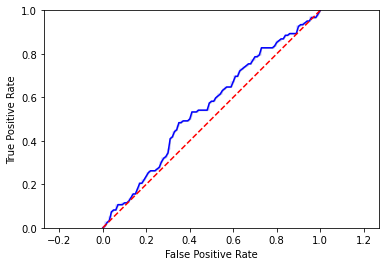

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/020--0.555--0.516.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[iii]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()